In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np 
import geopandas
from shapely.geometry import Point

# Load the CSV data
df = pd.read_csv("grow_attributes.csv", delimiter=';', low_memory=False)

# Extract starting and ending years for time-based analysis
df['starting_year'] = pd.to_datetime(df['starting_date']).dt.year
df['ending_year'] = pd.to_datetime(df['ending_date']).dt.year

# Define filter criteria for later use
df['over_30_years'] = df['length_years'] >= 30
df['gap_free'] = df['gap_fraction'] == 0.0
df['monthly'] = df['interval'] == 'MS'
df['ends_2023_or_later'] = df['ending_year'] >= 2023


world_map_filepath = r"C:\Users\tarik\Desktop\Maps" # world map file path

print("Libraries loaded and data initialized.")

Libraries loaded and data initialized.


## Global Data Overview

Dieser Abschnitt bietet einen ersten Überblick über den gesamten Datensatz und zeigt die globale Verteilung der Überwachungsstationen sowie verschiedene Attributzusammenfassungen über die Länder hinweg.

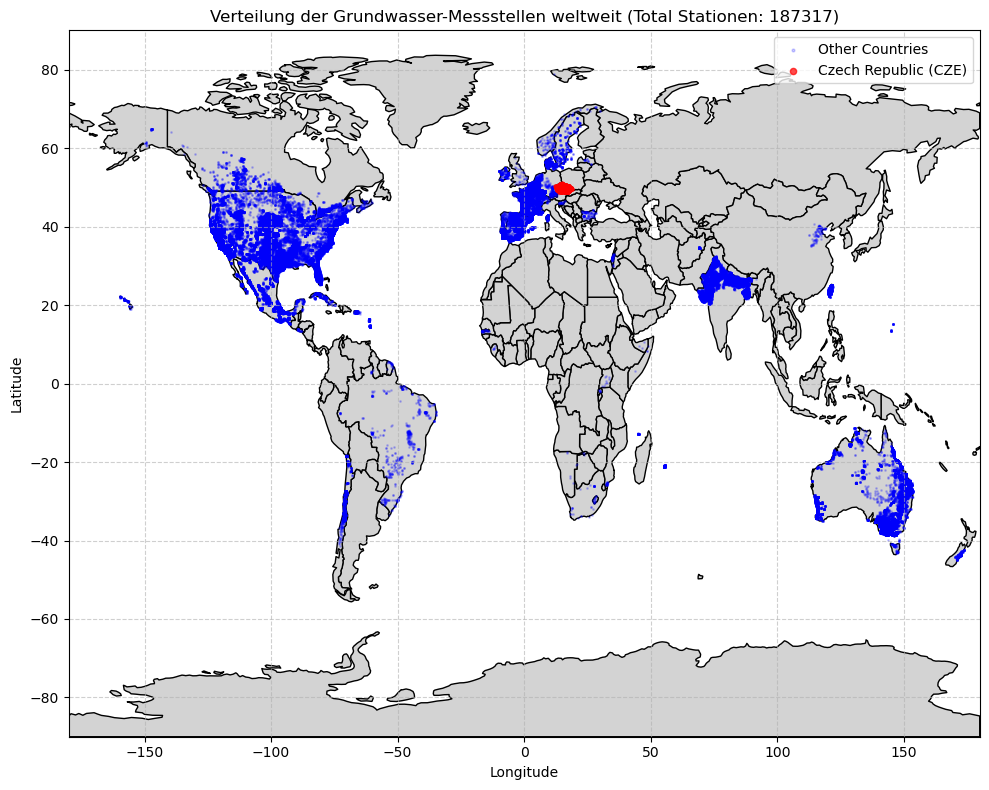

In [63]:
# Global Scatterplot of monitoring stations on a world map using geopandas
# This plot visualizes the geographic distribution of all groundwater monitoring stations, with Czech Republic stations highlighted.
if {'latitude', 'longitude'}.issubset(df.columns):
    # Create a GeoDataFrame from  DataFrame
    # Filter out rows with NaN in latitude or longitude 
    gdf_data = df.dropna(subset=['latitude', 'longitude']).copy()
    geometry = [Point(xy) for xy in zip(gdf_data['longitude'], gdf_data['latitude'])]
    gdf = geopandas.GeoDataFrame(gdf_data, geometry=geometry, crs="EPSG:4326") # coordinate system

    # Count the total number of monitoring stations that could be plotted
    total_stations_count = len(gdf)

    # Load the world map dataset from the local file
    world = None # Initialize world as None
    try:
        world = geopandas.read_file(world_map_filepath)
    except Exception as e:
        print(f"Error loading world map shapefile: {e}")
        print(f"Bitte stellen Sie sicher, dass '{world_map_filepath}' der korrekte Pfad zu Ihrer heruntergeladenen 'ne_110m_admin_0_countries.shp' Datei ist und alle zugehörigen Dateien (.shx, .dbf, etc.) im selben Verzeichnis liegen.")

    if world is not None:
        # Separate Czech Republic data from the rest for distinct coloring
        # Ensure 'country' column exists and 'CZE' is the correct code for Czech Republic
        if 'country' in gdf.columns:
            gdf_cz = gdf[gdf["country"] == "CZE"]
            gdf_other = gdf[gdf["country"] != "CZE"]
        else:
            print("Warnung: Spalte 'country' nicht gefunden. Alle Stationen werden als 'Other Countries' geplottet.")
            gdf_cz = geopandas.GeoDataFrame(columns=gdf.columns, geometry=[], crs="EPSG:4326") # Empty GeoDataFrame for CZE
            gdf_other = gdf # All stations are 'other'

        # Create the plot
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))

        # Plot the world map
        world.plot(ax=ax, color='lightgrey', edgecolor='black')

        # Plot non-Czech Republic stations
        gdf_other.plot(ax=ax, marker='o', color='blue', markersize=1, alpha=0.2, label='Other Countries')

        # Plot Czech Republic stations on top
        if not gdf_cz.empty:
            gdf_cz.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.7, label='Czech Republic (CZE)')

        # Updated title with total stations count
        ax.set_title(f"Verteilung der Grundwasser-Messstellen weltweit (Total Stationen: {total_stations_count})")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        # Set approximate world map limits
        ax.set_xlim([-180, 180])
        ax.set_ylim([-90, 90])

        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(markerscale=2)
        plt.tight_layout()
        plt.show()
    else:
        print("World map plot skipped due to shapefile loading error.")
else:
    print("Columns 'latitude' and 'longitude' not found. Skipping world map plot.")

Nutzen: Visualisierung der Verteilung der Messstellen. Erkenntnis: Daten sind weltweit vereteilt, höchste Messstelelendichte ist jedoch in den USA, Europa und Ost-Australien


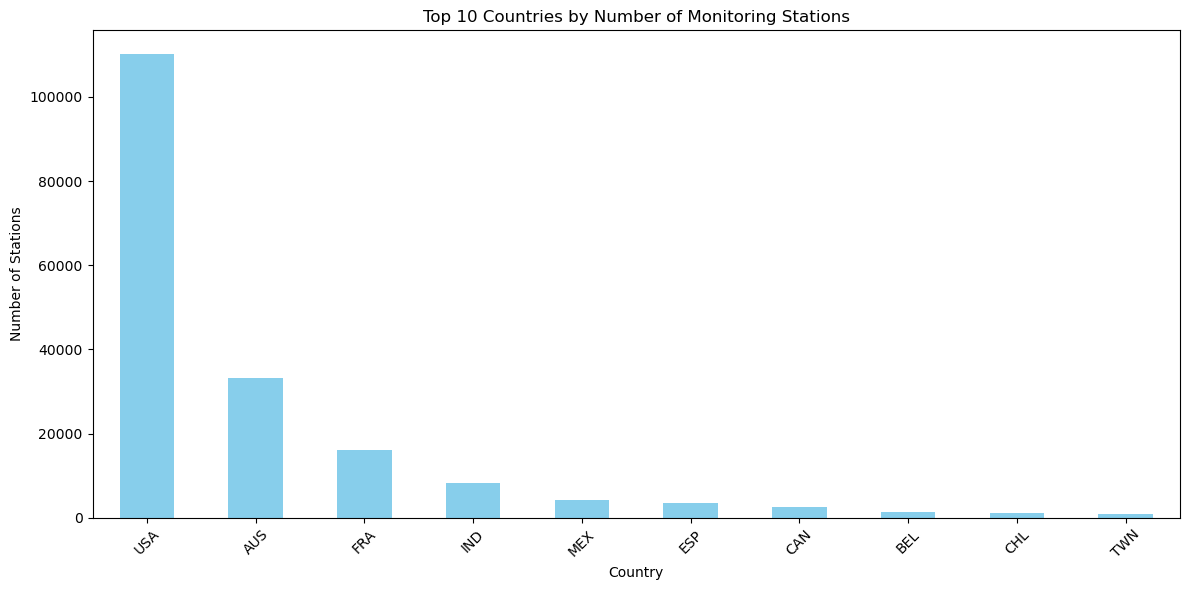

In [64]:
# Bar plot of the top 10 countries with the most monitoring stations
# This plot highlights the countries with the largest number of groundwater monitoring points in the dataset.
plt.figure(figsize=(12,6))
df['country'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Countries by Number of Monitoring Stations")
plt.xlabel("Country")
plt.ylabel("Number of Stations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

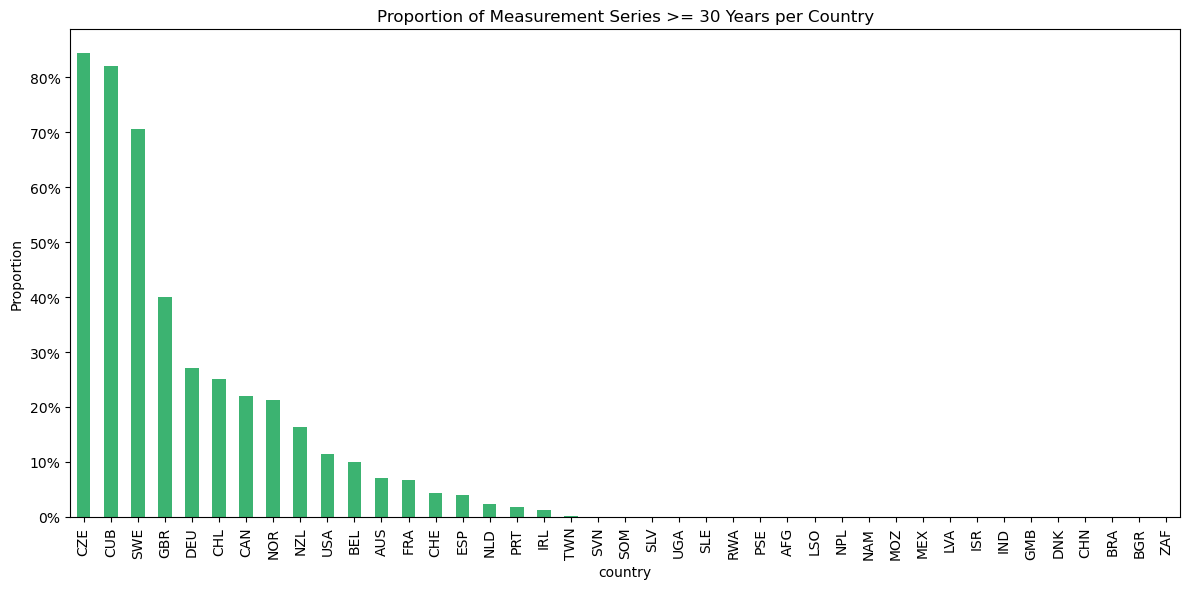

In [65]:
# Bar plot showing the proportion of measurement series >= 30 years per country
# This plot indicates which countries have a higher percentage of long-term groundwater monitoring series.
plt.figure(figsize=(12, 6))
ax = df.groupby('country')['over_30_years'].mean().sort_values(ascending=False).plot(kind='bar', color='mediumseagreen')
plt.title("Proportion of Measurement Series >= 30 Years per Country")
plt.ylabel("Proportion")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Erkenntnis über möglichst lange Messreihen. Fazit: CZE hat den höchsten Anteil an langen Messreihen

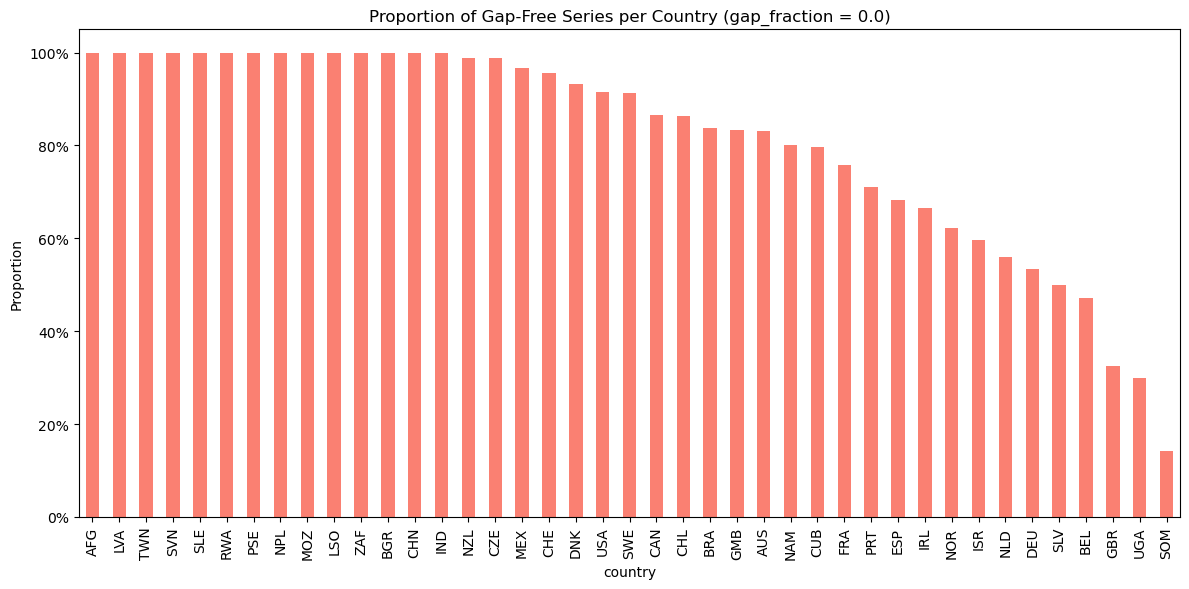

In [66]:
# Bar plot showing the proportion of gap-free series per country (gap_fraction = 0.0)
# This plot identifies countries with a higher proportion of complete (gap-free) groundwater measurement records.
plt.figure(figsize=(12, 6))
ax = df.groupby('country')['gap_free'].mean().sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title("Proportion of Gap-Free Series per Country (gap_fraction = 0.0)")
plt.ylabel("Proportion")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Erkenntniss über Luckenfreiheit der Messreihen einzelner Länder

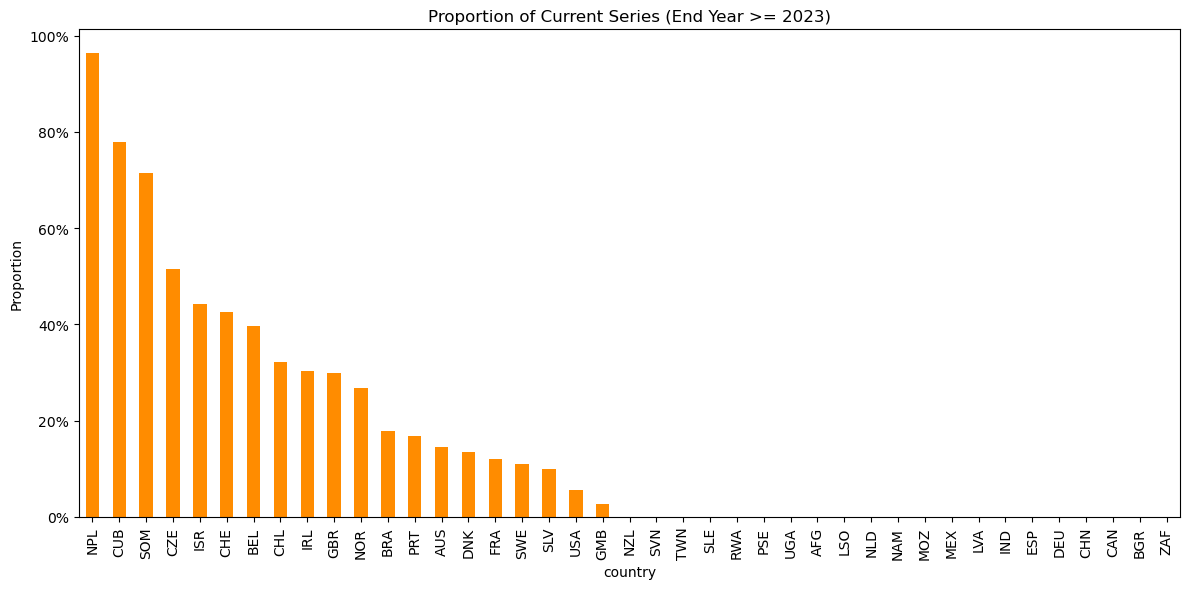

In [67]:
# Bar plot showing the proportion of current series (ending year >= 2023) per country
# This plot highlights countries with more up-to-date groundwater monitoring data.
plt.figure(figsize=(12, 6))
ax = df.groupby('country')['ends_2023_or_later'].mean().sort_values(ascending=False).plot(kind='bar', color='darkorange')
plt.title("Proportion of Current Series (End Year >= 2023)")
plt.ylabel("Proportion")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Erkentnis über Aktualität

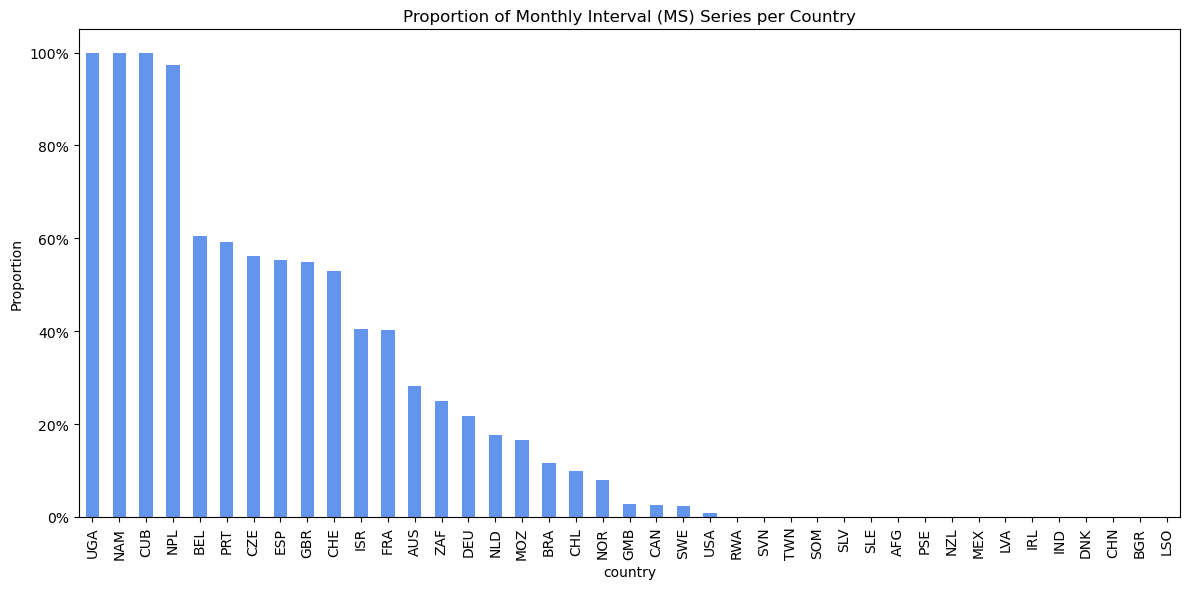

In [68]:
# Bar plot showing the proportion of monthly interval (MS) series per country
# This plot shows the prevalence of monthly measurement intervals across different countries.
plt.figure(figsize=(12, 6))
ax = df.groupby('country')['monthly'].mean().sort_values(ascending=False).plot(kind='bar', color='cornflowerblue')
plt.title("Proportion of Monthly Interval (MS) Series per Country")
plt.ylabel("Proportion")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Erkentnis über Aggreagtion der Messzeioten (jährlich, monatlich, täglich) -> Fokus auf Monatlich

C:\Users\tarik\AppData\Local\Temp\ipykernel_12120\3023759050.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')


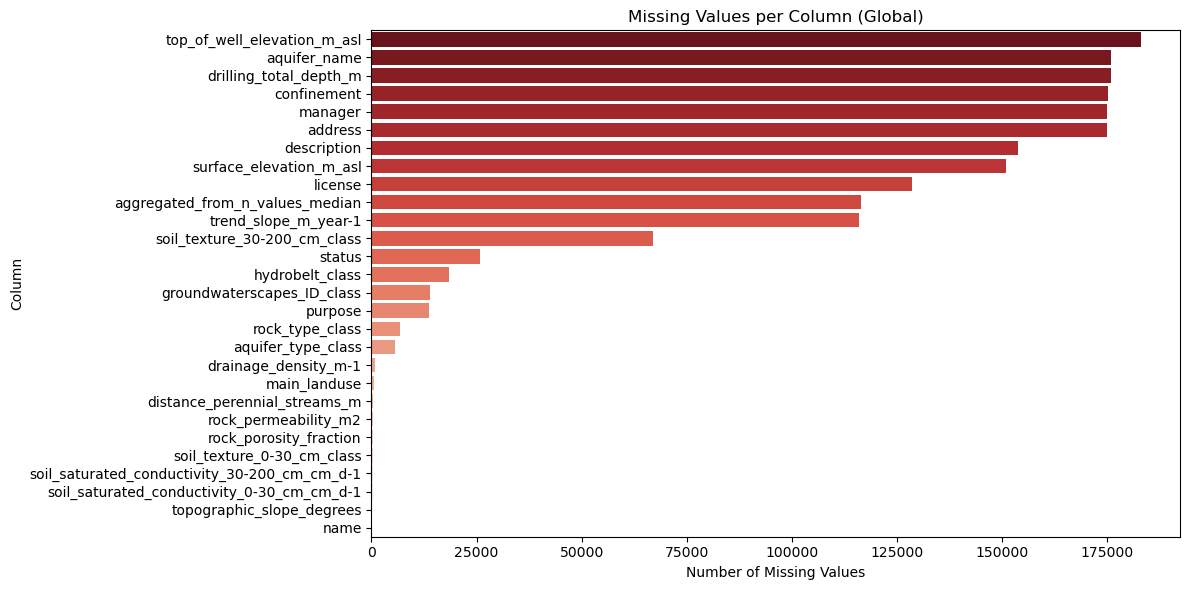

In [69]:
# Bar plot showing missing values per column across the entire dataset
# This plot helps to identify which columns have missing data and to what extent.
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]

if not missing.empty:
    plt.figure(figsize=(12,6))
    sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')
    plt.title("Missing Values per Column (Global)")
    plt.xlabel("Number of Missing Values")
    plt.ylabel("Column")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")

Information über Lücken in den Daten

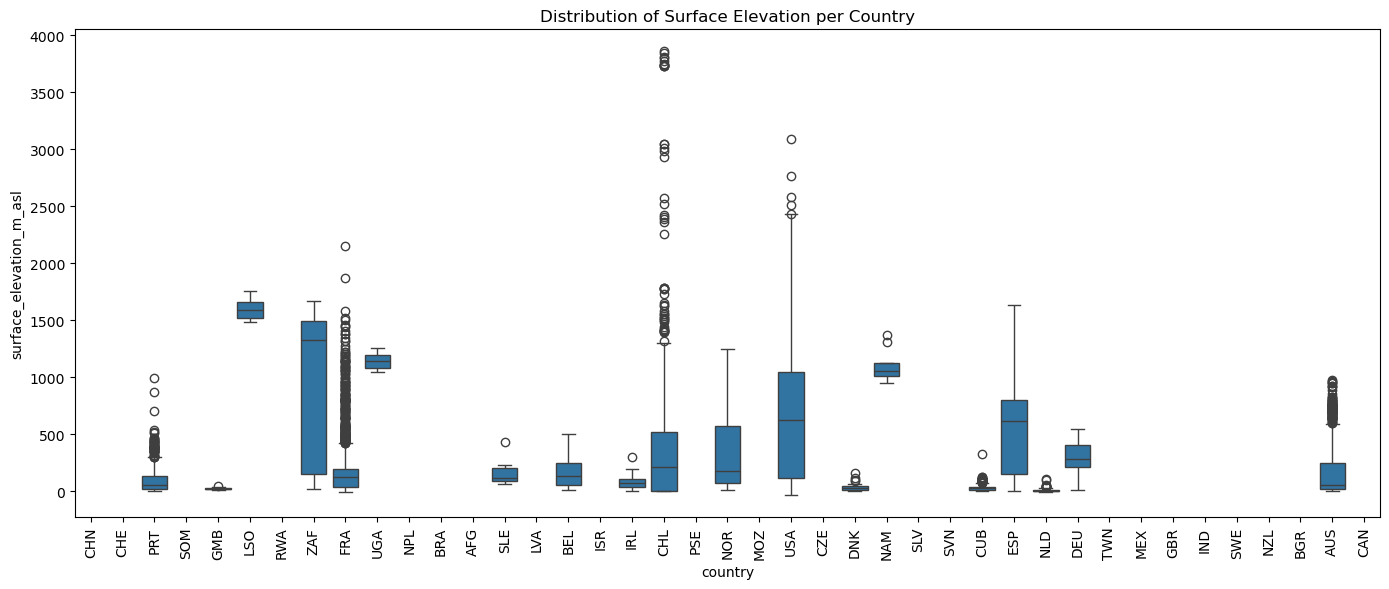

In [70]:
# Box plot showing the distribution of surface elevation per country
# This plot visualizes the range and median of station elevations for each country, helping to identify outliers.
if 'surface_elevation_m_asl' in df.columns:
    plt.figure(figsize=(14,6))
    sns.boxplot(x="country", y="surface_elevation_m_asl", data=df)
    plt.title("Distribution of Surface Elevation per Country")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'surface_elevation_m_asl' not found. Skipping elevation box plot.")

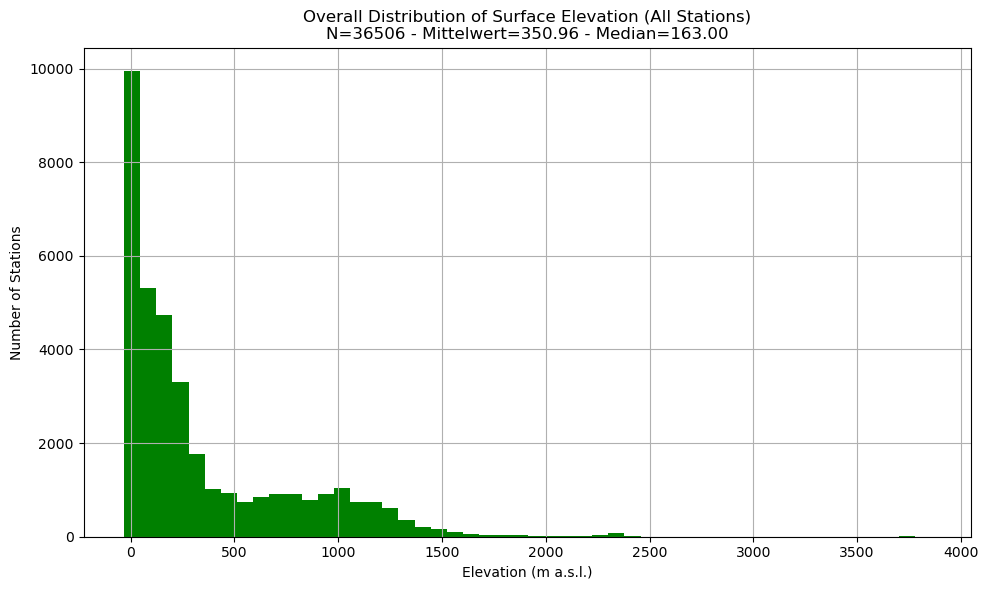

In [71]:
# Histogram showing the overall distribution of surface elevation for all monitoring stations
# Provides a general understanding of the altitude at which monitoring stations are located.
if 'surface_elevation_m_asl' in df.columns:
    # Mittelwert, Median und N
    elevation_mean = df['surface_elevation_m_asl'].mean()
    elevation_median = df['surface_elevation_m_asl'].median()
    elevation_count = df['surface_elevation_m_asl'].count() # Count non-null values for N

    plt.figure(figsize=(10,6))
    # .dropna() to ensure only valid Data gets plottet
    df['surface_elevation_m_asl'].dropna().hist(bins=50, color='green')
    plt.title(
        f"Overall Distribution of Surface Elevation (All Stations)\n"
        f"N={elevation_count} - Mittelwert={elevation_mean:.2f} - Median={elevation_median:.2f}"
    )
    plt.xlabel("Elevation (m a.s.l.)")
    plt.ylabel("Number of Stations")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'surface_elevation_m_asl' not found. Skipping elevation histogram.")


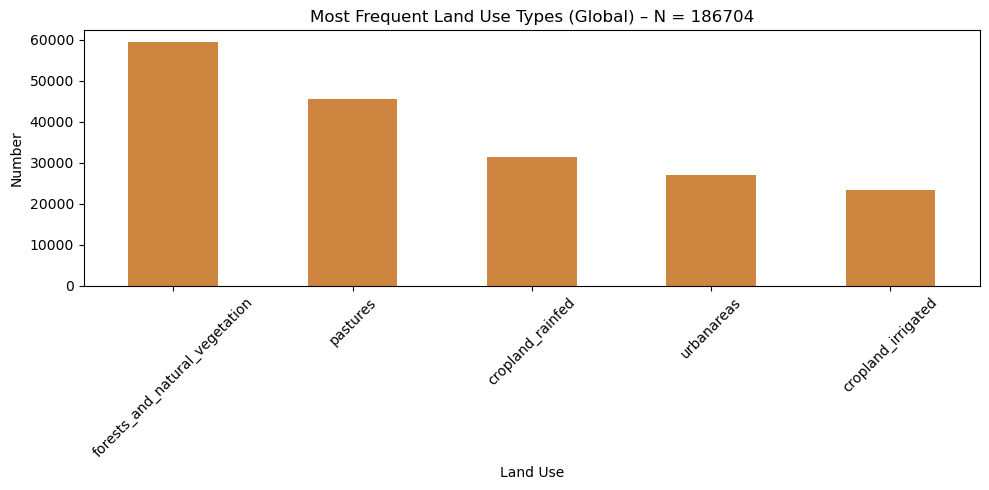

In [72]:
# Bar plot showing the most frequent land use types globally
# This plot illustrates the dominant land use categories associated with groundwater monitoring stations worldwide.
if 'main_landuse' in df.columns:
    plt.figure(figsize=(10, 5))
    landuse_counts = df['main_landuse'].value_counts()
    N = landuse_counts.sum()  
    landuse_counts.head(10).plot(kind='bar', color='peru')
    plt.title(f"Most Frequent Land Use Types (Global) – N = {N}")
    plt.xlabel("Land Use")
    plt.ylabel("Number")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'main_landuse' not found. Skipping land use bar plot.")


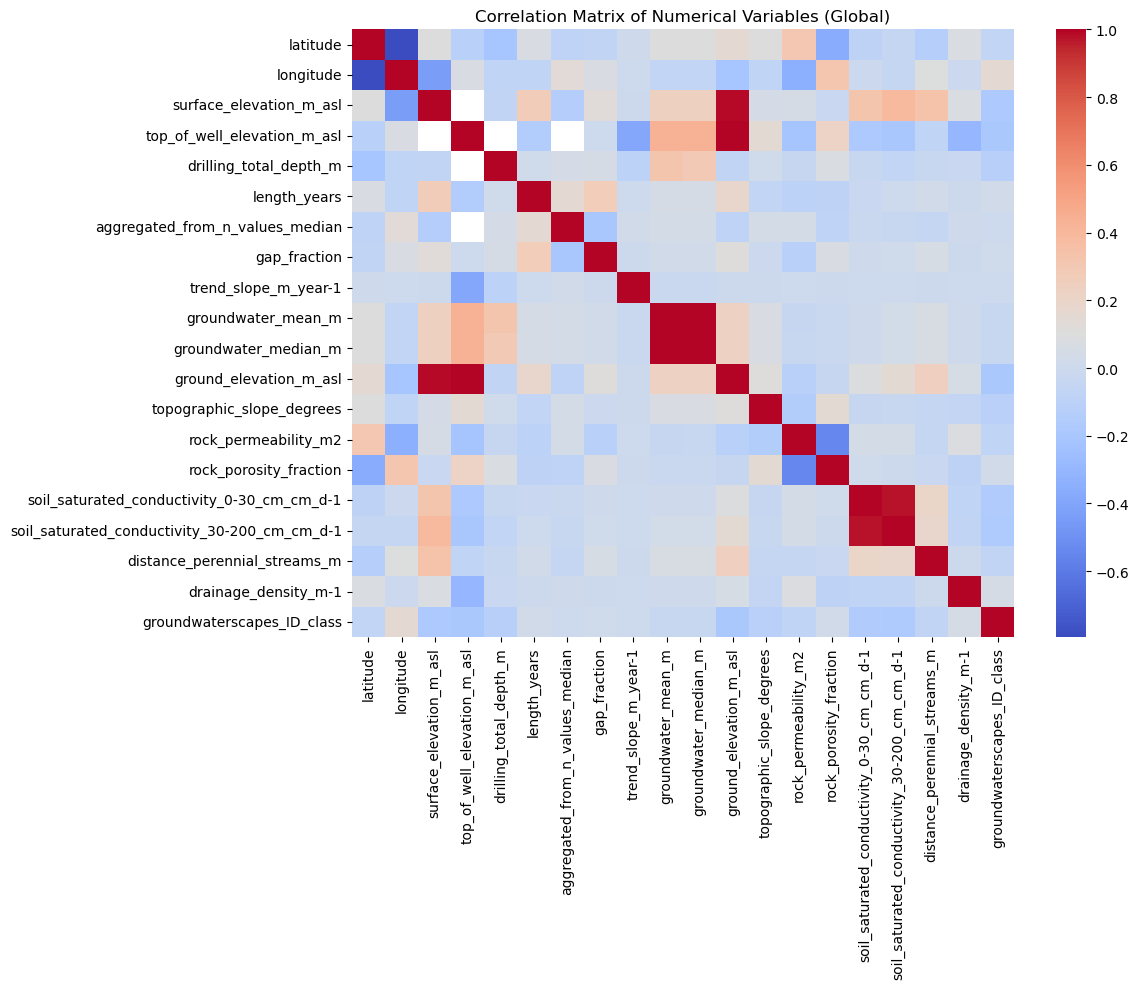

In [73]:
# Heatmap showing the correlation matrix of numerical variables across the entire dataset
# This heatmap visualizes the linear relationships between different numerical attributes in the dataset.
numeric_df = df.select_dtypes(include=['float64', 'int64'])
if not numeric_df.empty and len(numeric_df.columns) > 1:
    corr = numeric_df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Numerical Variables (Global)")
    plt.tight_layout()
    plt.show()
elif len(numeric_df.columns) <= 1:
    print("Not enough numerical columns for a correlation matrix (at least 2 needed). Skipping plot.")
else:
    print("No numerical columns found for a correlation matrix. Skipping plot.")

Hat für die ML Fragestellung und Zielsetzung wahrscheinlich keine Relevanz - dennoch interessant zu sehen

## Czech Republic (CZE) Specific Analysis


Dieser Abschnitt konzentriert sich speziell auf die Grundwasserüberwachungsstationen in der Tschechischen Republik (CZE) und bietet einen detaillierteren Einblick in ihre Eigenschaften.

Number of monitoring stations in the Czech Republic (CZE): 669


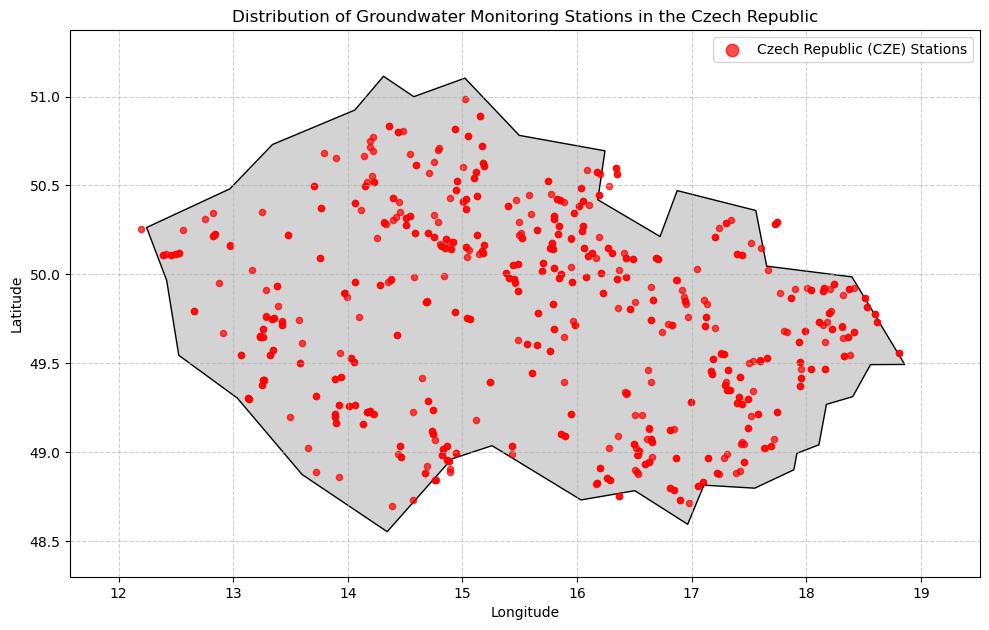

In [74]:
# Filter data for only the Czech Republic
df_cz = df[df["country"] == "CZE"].copy()

if df_cz.empty:
    raise ValueError("No data found for Czech Republic (CZE). Please check the input file and country code.")

print(f"Number of monitoring stations in the Czech Republic (CZE): {len(df_cz)}")

# Focused map of monitoring stations in the Czech Republic using geopandas
# This map provides a detailed view of the distribution of stations within the Czech Republic.
if {'latitude', 'longitude'}.issubset(df_cz.columns):
    # Create a GeoDataFrame for CZE data
    geometry_cz = [Point(xy) for xy in zip(df_cz['longitude'], df_cz['latitude'])]
    gdf_cz_map = geopandas.GeoDataFrame(df_cz, geometry=geometry_cz, crs="EPSG:4326")

    # Load the world map (and filter for CZE bounds to draw background) - or just load CZE country boundary if available
    try:
        world = geopandas.read_file(world_map_filepath)
        # Filter world map to just Czech Republic for background
        cz_boundary = world[world['ADM0_A3'] == 'CZE'] # 'ADM0_A3' is typically the 3-letter country code in Natural Earth
        if cz_boundary.empty:
            print("Czech Republic boundary not found in the loaded world map. Plotting points without a country background.")
            cz_boundary = None
    except Exception as e:
        print(f"Error loading world map for CZE boundary: {e}")
        cz_boundary = None

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    if cz_boundary is not None:
        cz_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')

    # Plot Czech Republic stations
    gdf_cz_map.plot(ax=ax, marker='o', color='red', markersize=20, alpha=0.7, label='Czech Republic (CZE) Stations')

    ax.set_title("Distribution of Groundwater Monitoring Stations in the Czech Republic")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Set appropriate limits for the Czech Republic 
    if cz_boundary is not None and not cz_boundary.empty:
        minx, miny, maxx, maxy = cz_boundary.total_bounds
        # padding 
        padding_x = (maxx - minx) * 0.1
        padding_y = (maxy - miny) * 0.1
        ax.set_xlim(minx - padding_x, maxx + padding_x)
        ax.set_ylim(miny - padding_y, maxy + padding_y)
    else:
        # Fallback to hardcoded limits if boundary not loaded/found
        ax.set_xlim(12.0, 19.0)
        ax.set_ylim(48.5, 51.5)

    ax.grid(True, linestyle='--', alpha=0.6)

    ax.legend(markerscale=2)
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'latitude' and 'longitude' not found in the CZE DataFrame. Skipping CZE map plot.")

Fazit: Große Dichte an Messtellen


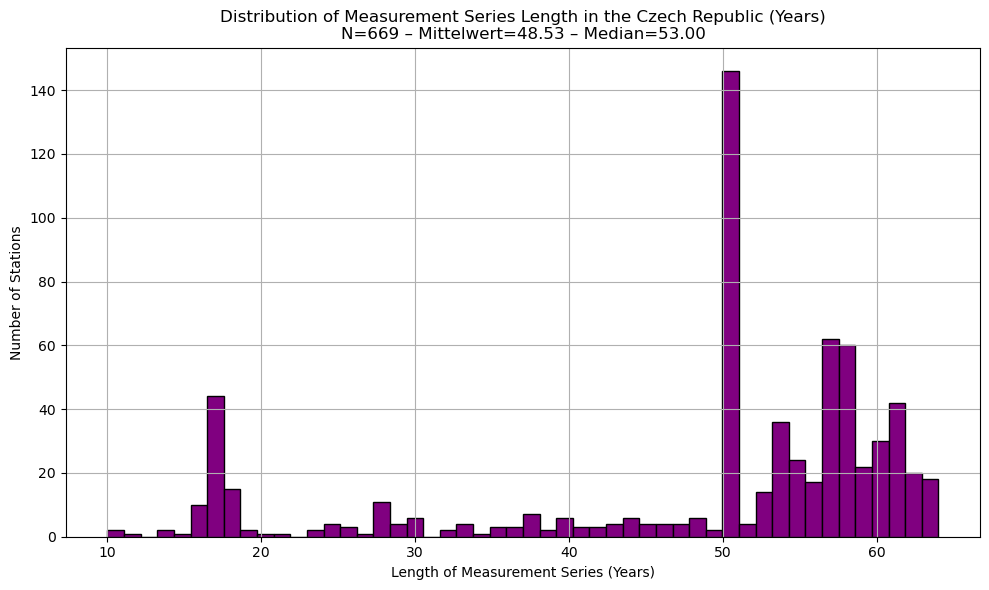

In [75]:
# Histogram showing the distribution of measurement series length in the Czech Republic
# This plot provides insights into how long monitoring data has been collected at stations in the Czech Republic.

if 'length_years' in df_cz.columns:
    # Key Values
    series_lengths = df_cz['length_years'].dropna()
    mean_length = series_lengths.mean()
    median_length = series_lengths.median()
    count_length = series_lengths.count()

    # Generate Plot 
    plt.figure(figsize=(10, 6))
    series_lengths.hist(bins=50, color='purple', edgecolor='black')
    plt.title(
        f"Distribution of Measurement Series Length in the Czech Republic (Years)\n"
        f"N={count_length} – Mittelwert={mean_length:.2f} – Median={median_length:.2f}"
    )
    plt.xlabel("Length of Measurement Series (Years)")
    plt.ylabel("Number of Stations")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'length_years' not found in df_cz. Skipping histogram.")


Fazit: Hohe Dichte an langen Messreihen

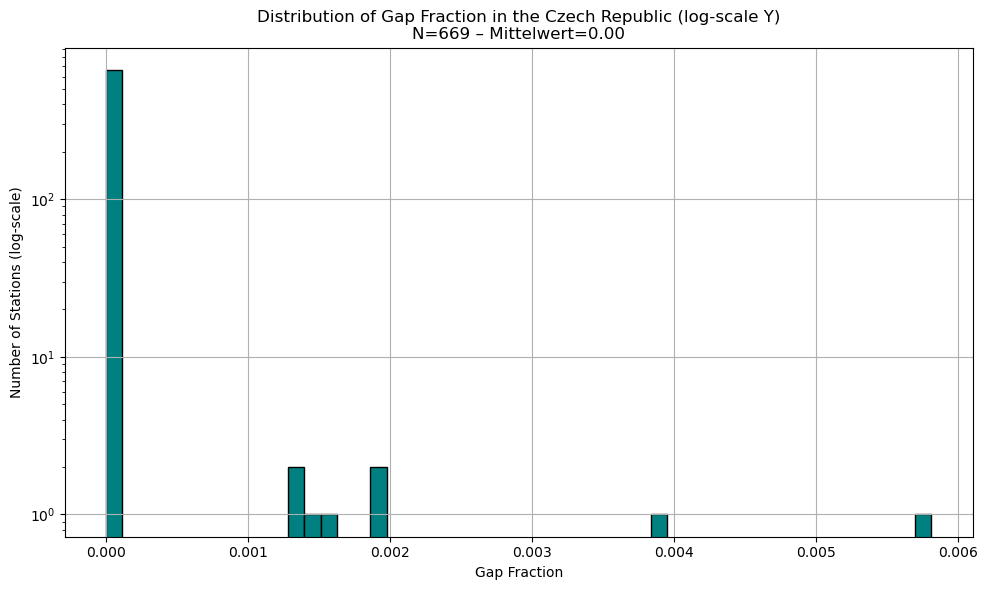

In [76]:
# Histogram showing the distribution of gap fraction in the Czech Republic (with log-scale y-axis)
# This plot helps to understand the completeness of data, with a log scale to emphasize the frequency of low gap fractions.

if 'gap_fraction' in df_cz.columns:
    #  Key Values
    gap_values = df_cz['gap_fraction'].dropna()
    mean_gap = gap_values.mean()

    count_gap = gap_values.count()

    # Genertate Plot
    plt.figure(figsize=(10, 6))
    gap_values.hist(bins=50, color='teal', edgecolor='black')
    plt.title(
        f"Distribution of Gap Fraction in the Czech Republic (log-scale Y)\n"
        f"N={count_gap} – Mittelwert={mean_gap:.2f}"
    )
    plt.xlabel("Gap Fraction")
    plt.ylabel("Number of Stations (log-scale)")
    plt.yscale('log')  # Logarithmic y-Axis
    plt.tight_layout()
    plt.show()
else:
    print("Column 'gap_fraction' not found in df_cz. Skipping histogram.")


Fazit: Wenige Lücken

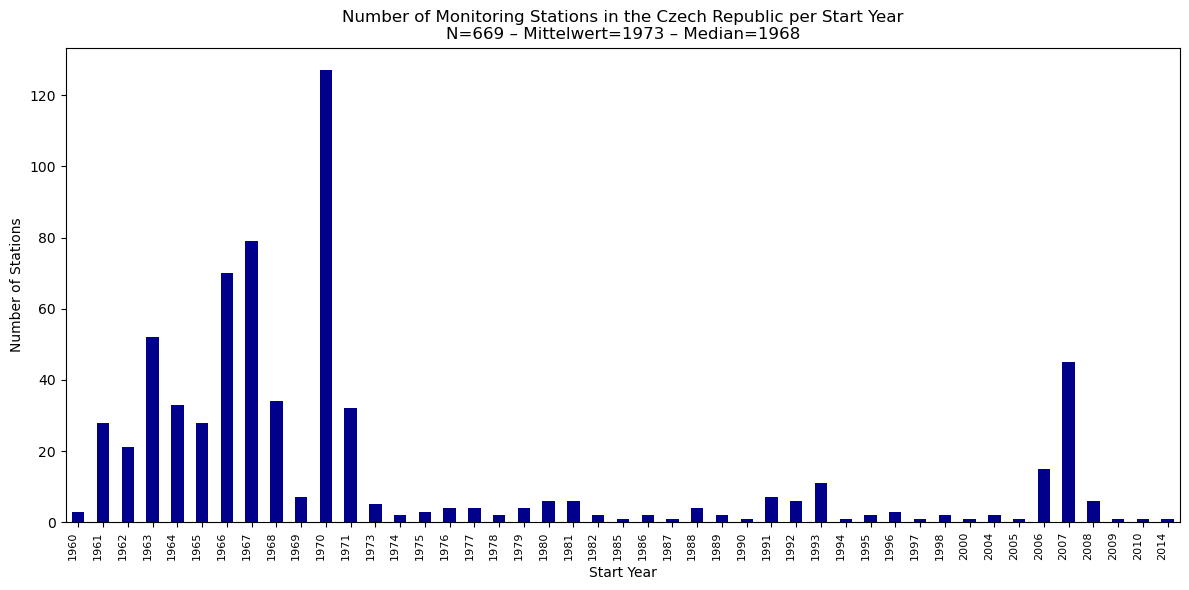

In [77]:
# Bar plot showing the number of monitoring stations in the Czech Republic per start year
# This plot illustrates the temporal evolution of the monitoring network in the Czech Republic, showing when most stations were established.

if 'starting_year' in df_cz.columns:
    #   Key Values
    start_years = df_cz['starting_year'].dropna()
    count_start = start_years.count()
    mean_start = start_years.mean()
    median_start = start_years.median()

    # Generatee Plot    
    plt.figure(figsize=(12, 6))
    start_years.value_counts().sort_index().plot(kind='bar', color='darkblue')
    plt.title(
        f"Number of Monitoring Stations in the Czech Republic per Start Year\n"
        f"N={count_start} – Mittelwert={mean_start:.0f} – Median={median_start:.0f}"
    )
    plt.xlabel("Start Year")
    plt.ylabel("Number of Stations")
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'starting_year' not found in df_cz. Skipping plot.")


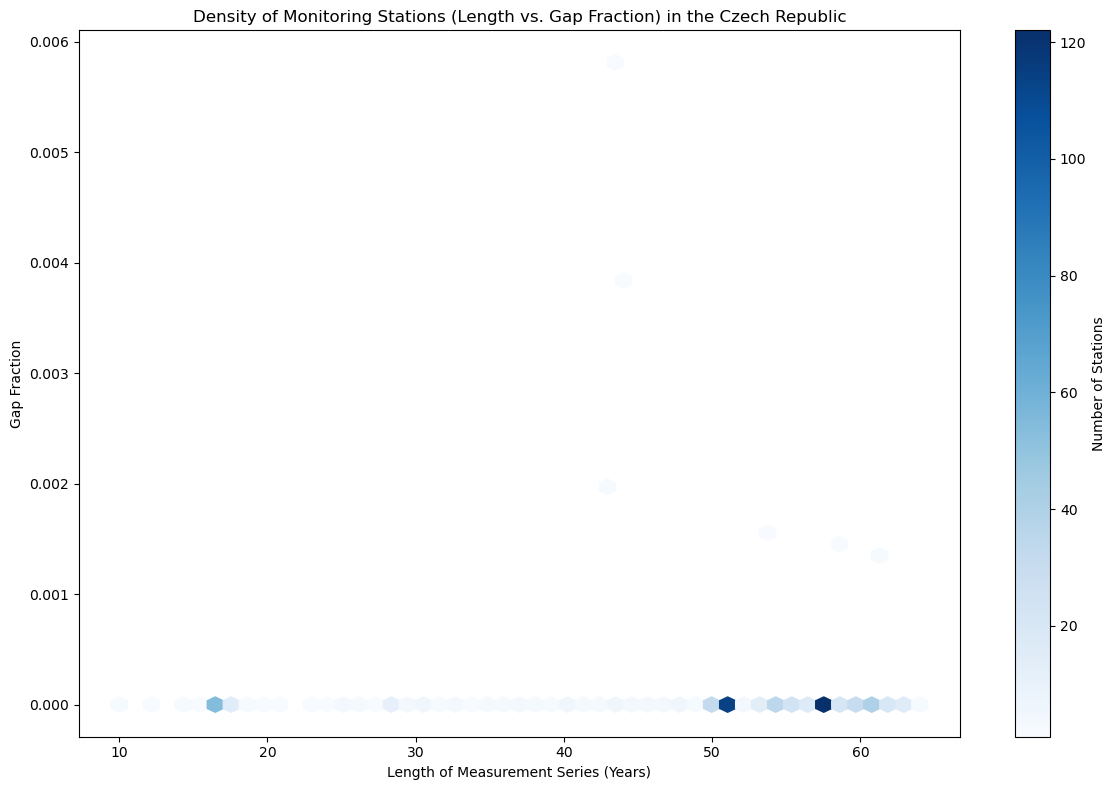

In [78]:
# Hexbin plot showing the density of monitoring stations based on length and gap fraction in the Czech Republic
# This plot reveals clusters of stations based on how long they've been recording and how complete their data is.
plt.figure(figsize=(12, 8))
plt.hexbin(df_cz['length_years'], df_cz['gap_fraction'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Stations')
plt.title("Density of Monitoring Stations (Length vs. Gap Fraction) in the Czech Republic")
plt.xlabel("Length of Measurement Series (Years)")
plt.ylabel("Gap Fraction")
plt.tight_layout()
plt.show()

Fazit: Ein großer Anteil der Messstationen zeichnet sich durch lückenlose Zeitreihen aus und verfügt über sehr lange Messreihen (50 bis 60 Jahre).

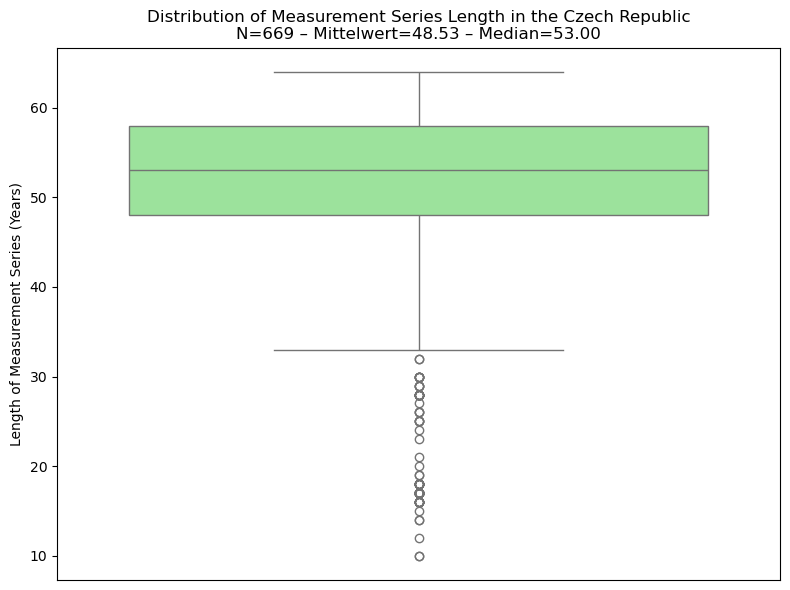

In [79]:
# Box plot showing the distribution of measurement series length in the Czech Republic
# Provides a concise summary of the central tendency and spread of measurement series lengths, and identifies outliers.

if 'length_years' in df_cz.columns:
    # Key Values
    series_lengths = df_cz['length_years'].dropna()
    count_length = series_lengths.count()
    mean_length = series_lengths.mean()
    median_length = series_lengths.median()

    # Generate Plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=series_lengths, color='lightgreen')
    plt.title(
        f"Distribution of Measurement Series Length in the Czech Republic\n"
        f"N={count_length} – Mittelwert={mean_length:.2f} – Median={median_length:.2f}"
    )
    plt.ylabel("Length of Measurement Series (Years)")
    plt.xticks([])  
    plt.tight_layout()
    plt.show()
else:
    print("Column 'length_years' not found in df_cz. Skipping box plot.")


Auch hier nochmal: hohe Dichte an langen Messreihen

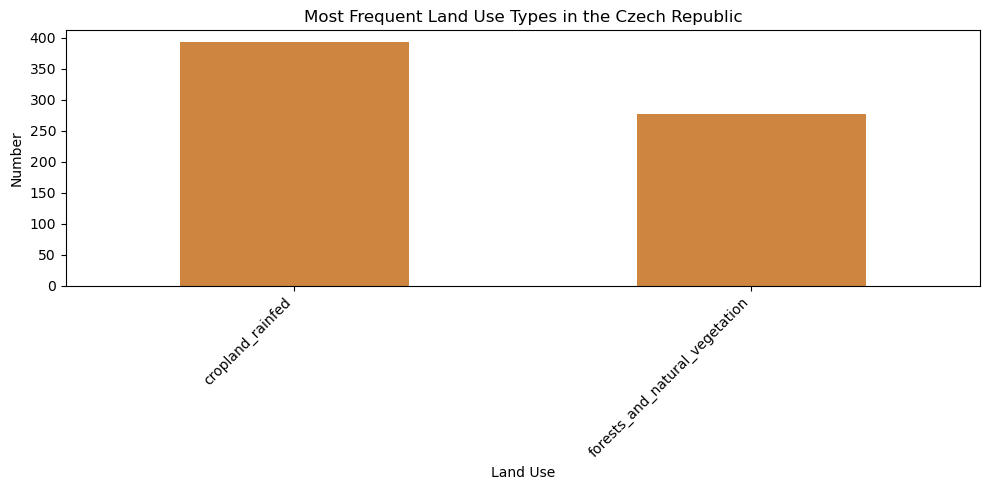

In [80]:
# Bar plot showing the most frequent land use types in the Czech Republic
# This plot highlights the common land use categories around monitoring stations specifically in the Czech Republic.
if 'main_landuse' in df_cz.columns and not df_cz['main_landuse'].dropna().empty:
    plt.figure(figsize=(10, 5))
    df_cz['main_landuse'].value_counts().head(10).plot(kind='bar', color='peru')
    plt.title("Most Frequent Land Use Types in the Czech Republic")
    plt.xlabel("Land Use")
    plt.ylabel("Number")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'main_landuse' is not present or empty for the Czech Republic. Skipping plot.")

In [81]:
# Histogram showing the distribution of surface elevation of monitoring stations in the Czech Republic
# This histogram provides insight into the typical altitudes of groundwater monitoring points within the Czech Republic.
if 'surface_elevation_m_asl' in df_cz.columns and not df_cz['surface_elevation_m_asl'].dropna().empty:
    plt.figure(figsize=(10, 6))
    df_cz['surface_elevation_m_asl'].dropna().hist(bins=50, color='olive', edgecolor='black')
    plt.title("Distribution of Surface Elevation of Monitoring Stations in the Czech Republic")
    plt.xlabel("Elevation (m a.s.l.)")
    plt.ylabel("Number")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'surface_elevation_m_asl' is not present or empty for the Czech Republic. Skipping plot.")

Column 'surface_elevation_m_asl' is not present or empty for the Czech Republic. Skipping plot.


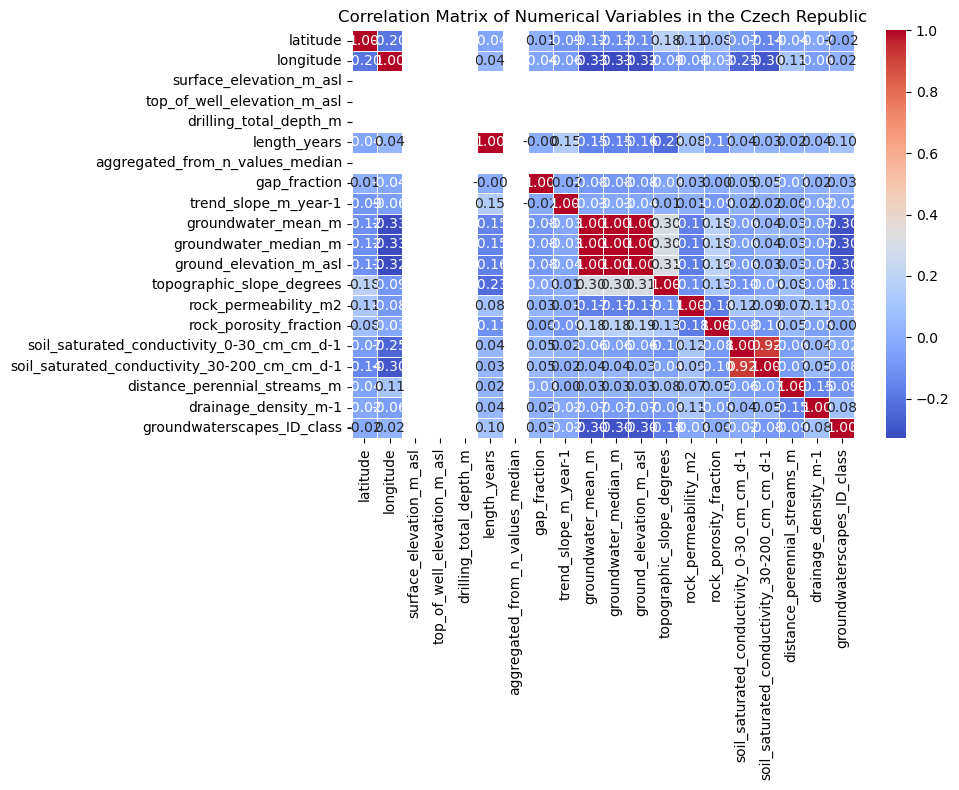

In [82]:
# Heatmap showing the correlation matrix of numerical variables in the Czech Republic
# This heatmap visualizes the linear relationships between different numerical attributes for stations in the Czech Republic.
numeric_cols_cz = df_cz.select_dtypes(include=['float64', 'int64']).columns
if len(numeric_cols_cz) > 1:
    corr_cz = df_cz[numeric_cols_cz].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_cz, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title("Correlation Matrix of Numerical Variables in the Czech Republic")
    plt.tight_layout()
    plt.show()
elif len(numeric_cols_cz) <= 1:
    print("Not enough numerical columns for a correlation matrix in the Czech Republic (at least 2 needed). Skipping plot.")
else:
    print("No numerical columns found for a correlation matrix in the Czech Republic. Skipping plot.")

Auch hier: Wahrscheinlich geringe Relevanz für uns, dennoch trotzdem Interessant zu sehen. Weitere Erkenntniss: 4 Spalten sind in CZE komplett leer

# Wichtige Notiz

### Im Folgenden Abschnitt haben wir abschließend  Schleifen implementiert, die systematisch alle numerischen Spalten in Form von Histogrammen und Boxplots sowie alle kategorialen Spalten als Balkendiagramme mit den Häufigkeiten der Kategorien visualisieren. Dabei war das Ziel nicht, für alles nützliche Plots zu erzeugen, sondern durch die umfassende Visualisierung unerwartete Muster oder Auffälligkeiten zu entdecken. Viele der Plots lieferten zwar keine neuen Erkenntnisse oder waren für bestimmte Merkmale (wie beispielsweise die Longitude) wenig aussagekräftig. Dennoch ermöglichte uns diese ganzheitliche Vorgehensweise, einzelne Details und Besonderheiten zu identifizieren, die uns sonst möglicherweise entgangen wären.


Further detailed plots for Czech Republic (CZE) data:

Missing values for Czech Republic (CZE) data:
GROW_ID                                           0
original_ID_groundwater                           0
name                                              0
feature_type                                      0
purpose                                           0
status                                            0
description                                     669
latitude                                          0
longitude                                         0
surface_elevation_m_asl                         669
top_of_well_elevation_m_asl                     669
country                                           0
address                                         669
license                                           0
aquifer_name                                    669
confinement                                     669
organisation                                      0
manager       

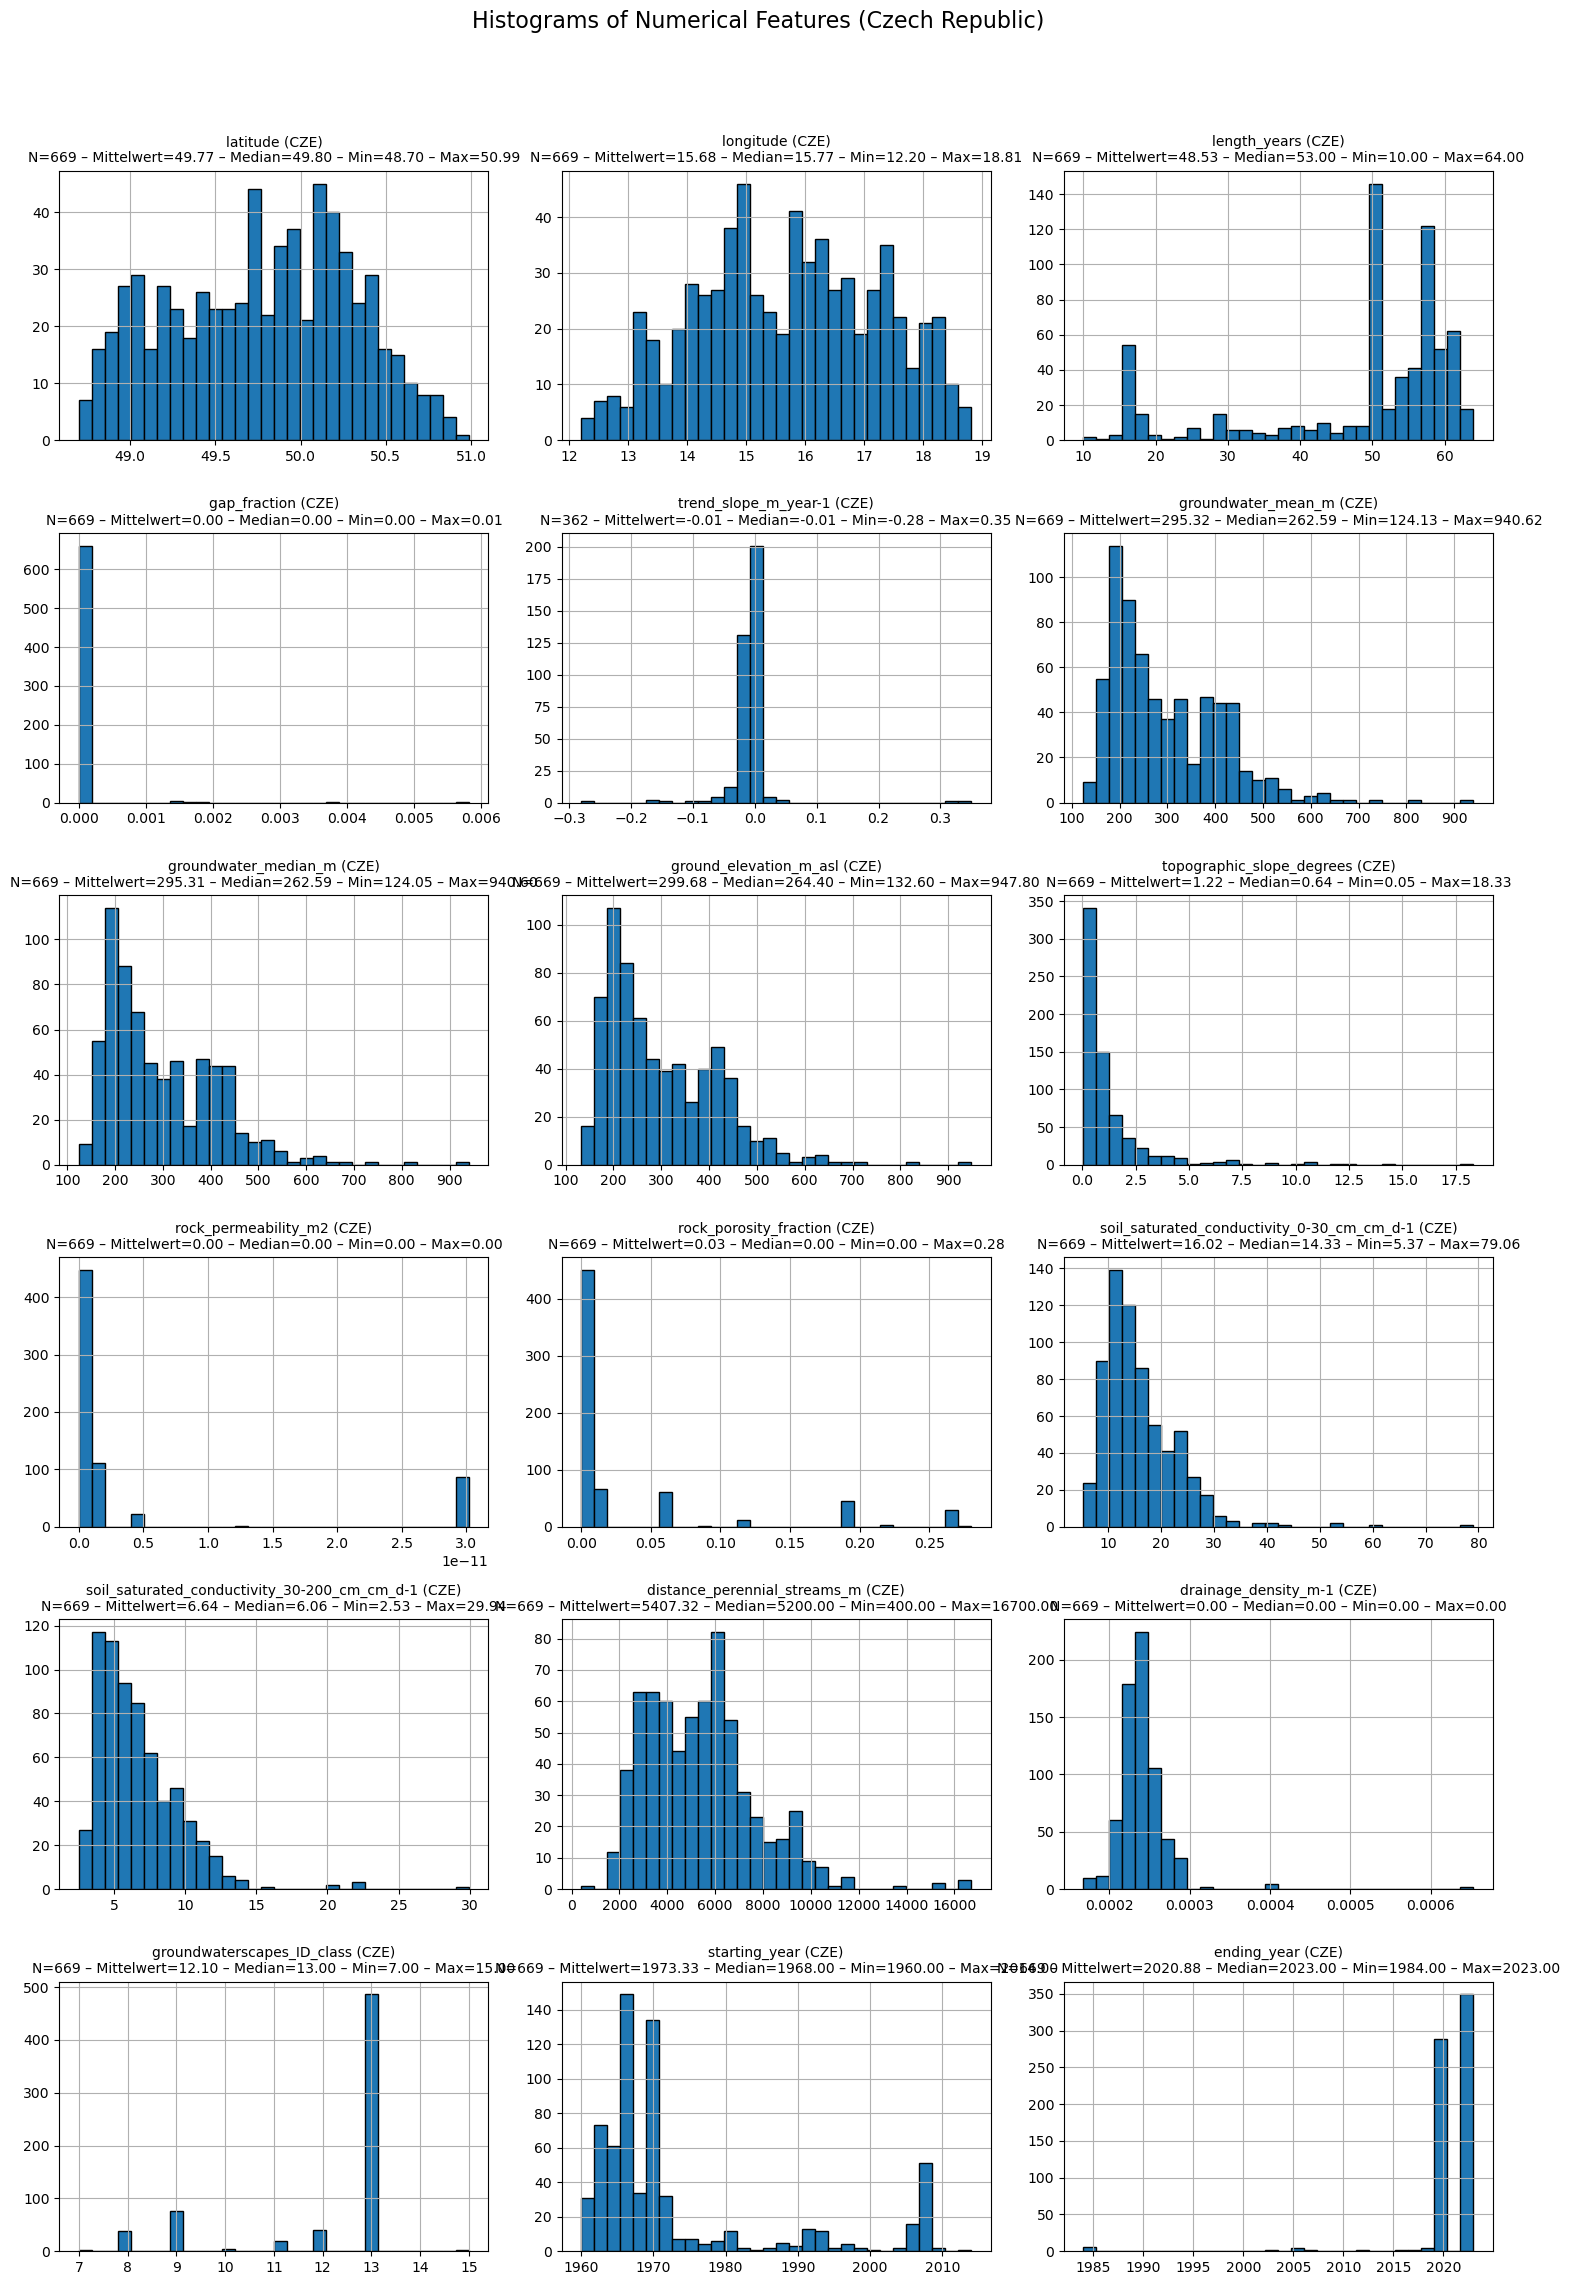

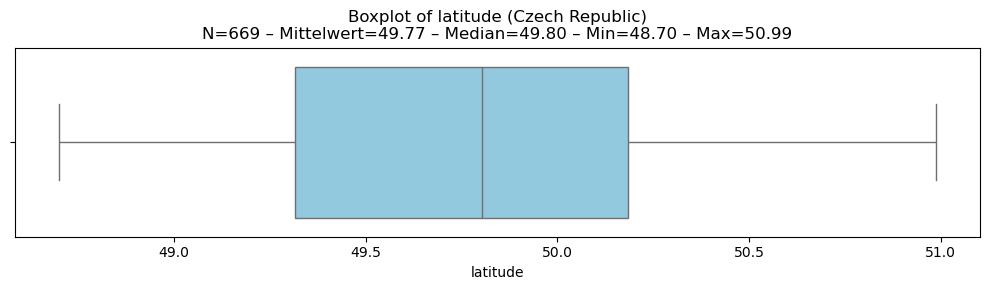

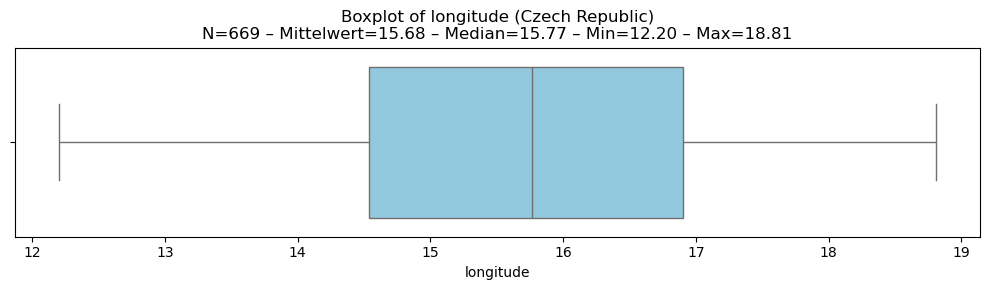

Skipping Boxplot for 'surface_elevation_m_asl' (Czech Republic): Not enough diverse or no non-missing values.
Skipping Boxplot for 'top_of_well_elevation_m_asl' (Czech Republic): Not enough diverse or no non-missing values.
Skipping Boxplot for 'drilling_total_depth_m' (Czech Republic): Not enough diverse or no non-missing values.


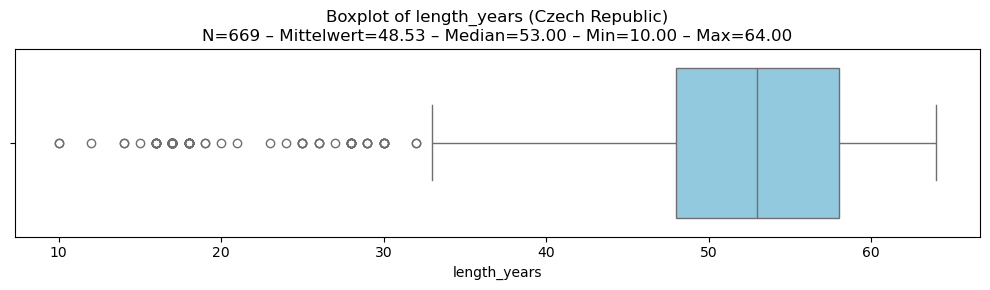

Skipping Boxplot for 'aggregated_from_n_values_median' (Czech Republic): Not enough diverse or no non-missing values.


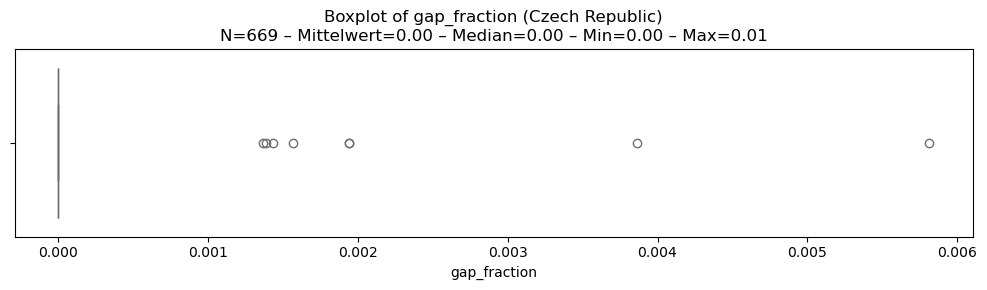

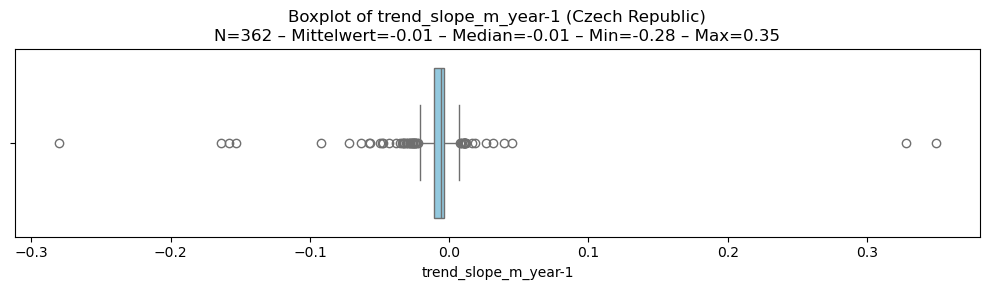

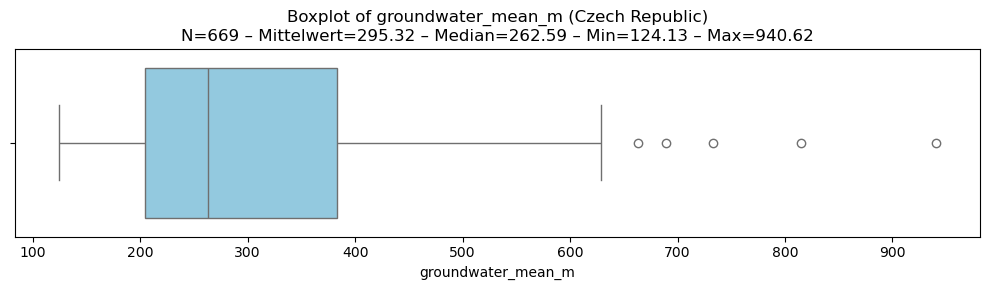

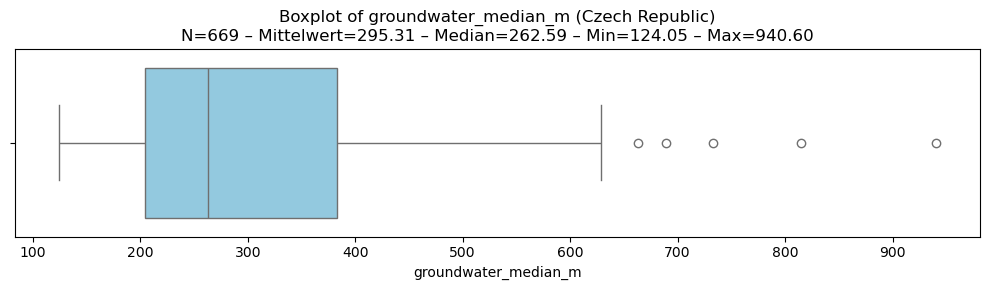

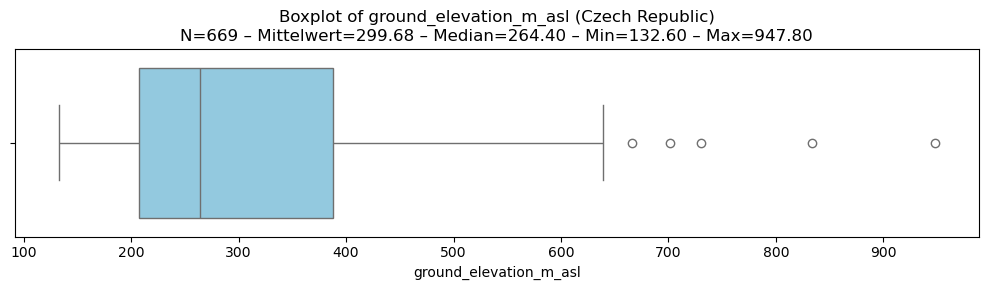

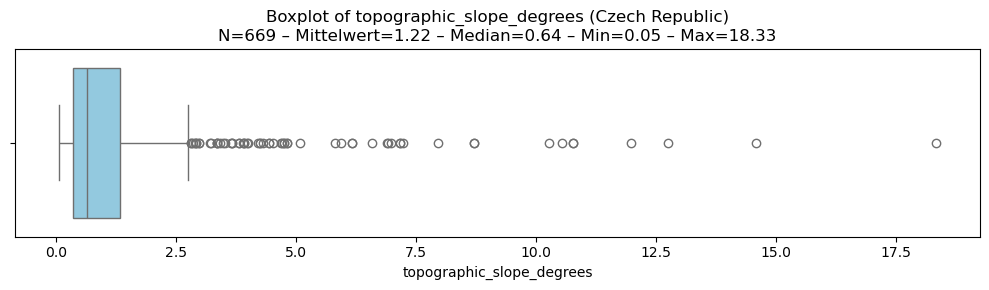

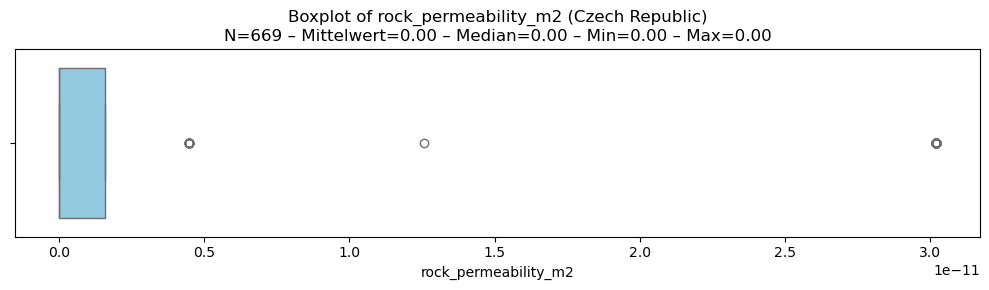

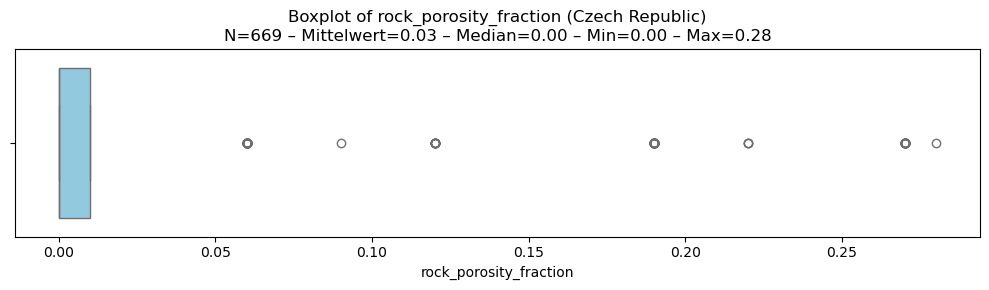

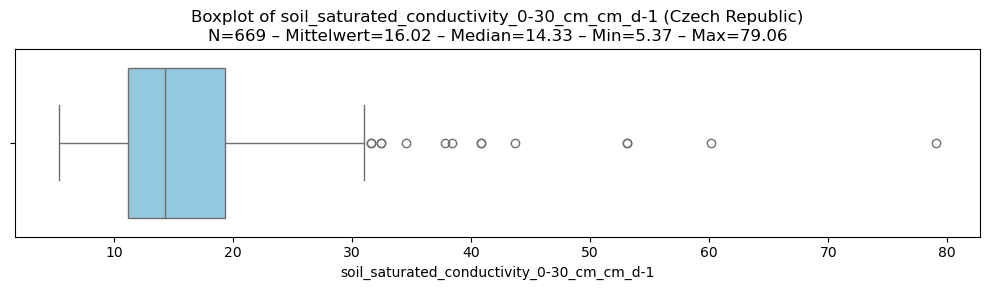

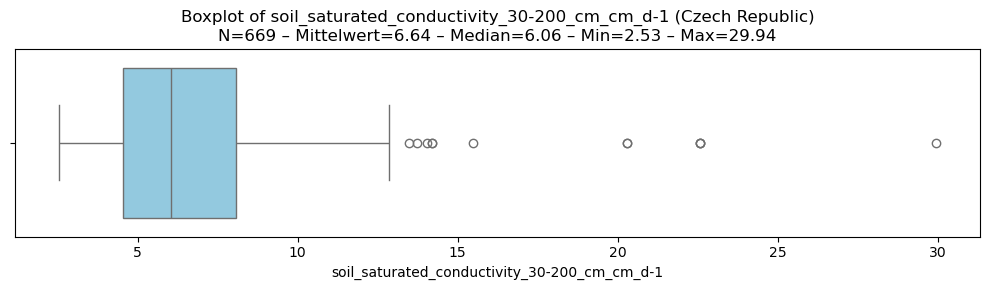

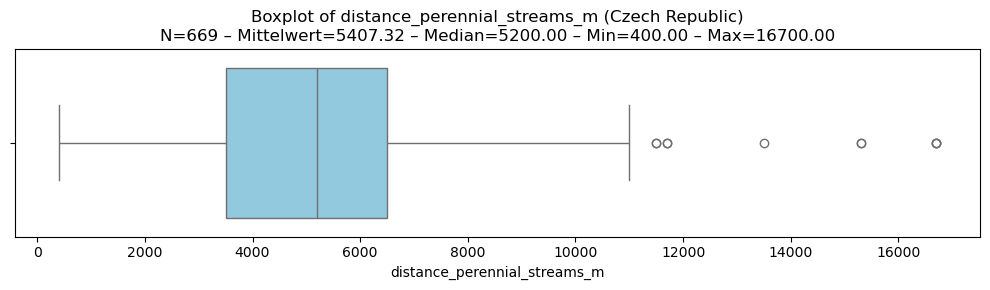

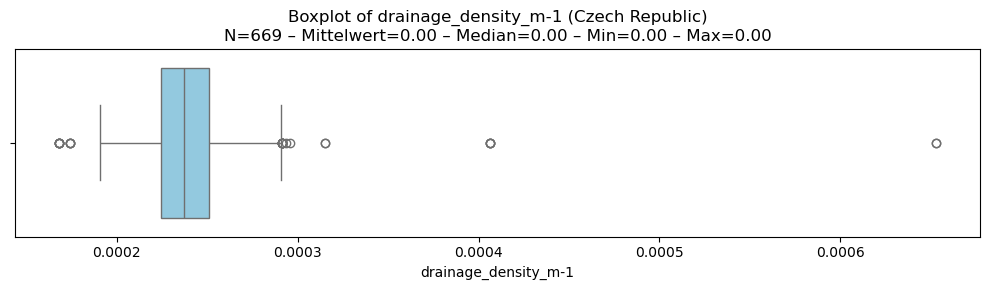

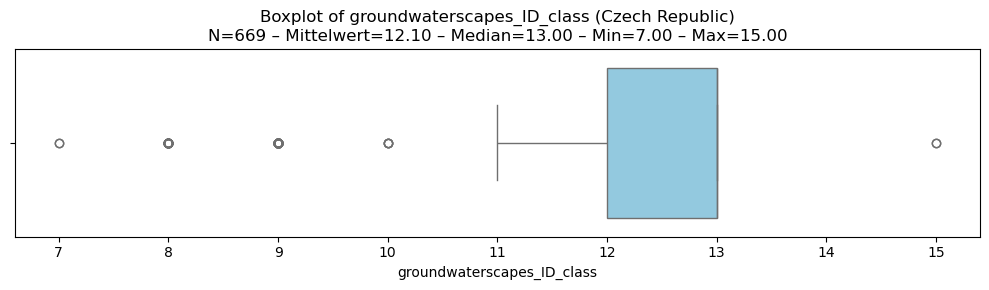

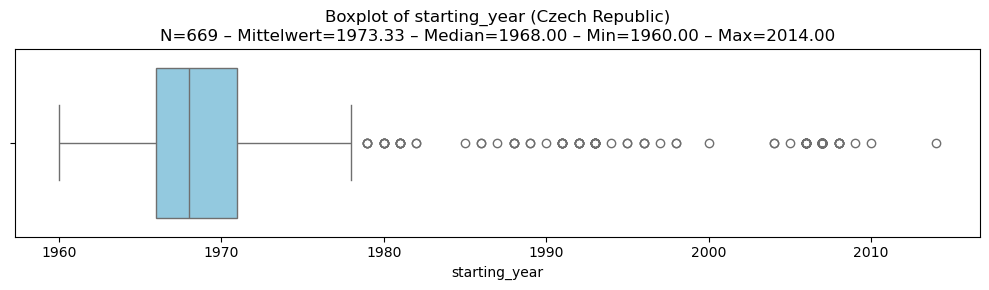

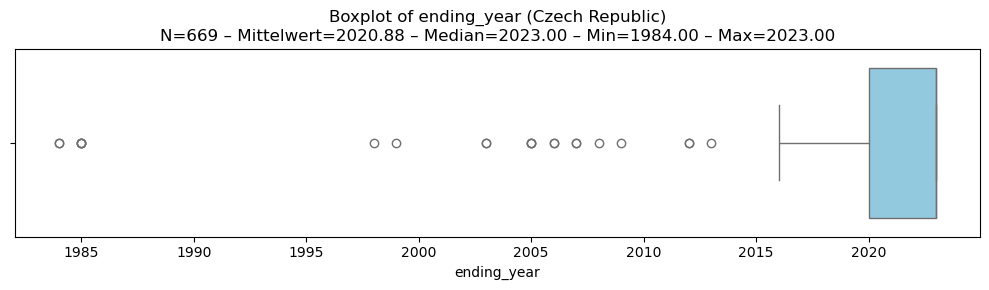

Column 'GROW_ID' in CZE data has too many unique values (669). Plotting top 10 most frequent categories.


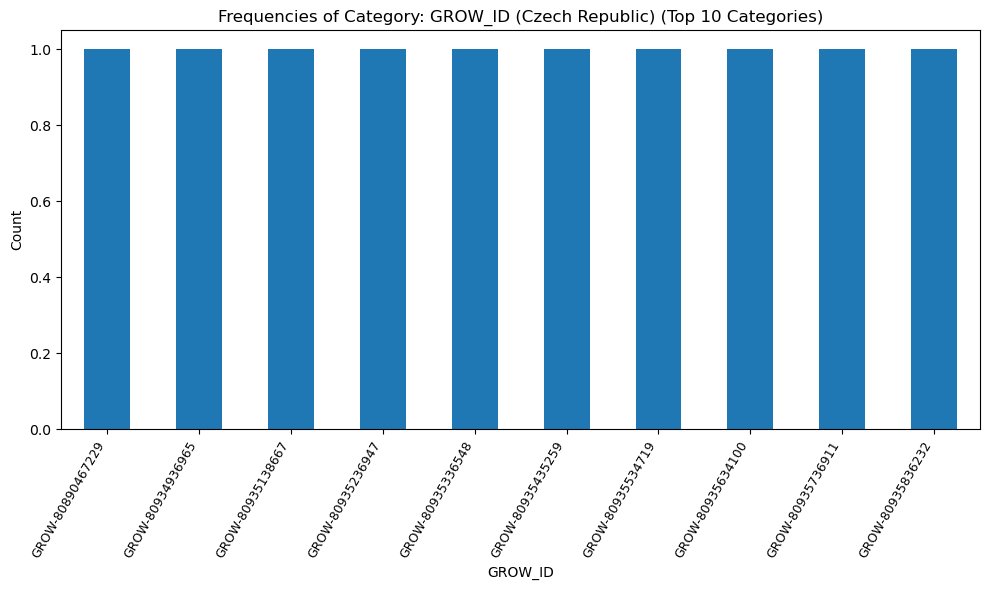

Column 'original_ID_groundwater' in CZE data has too many unique values (669). Plotting top 10 most frequent categories.


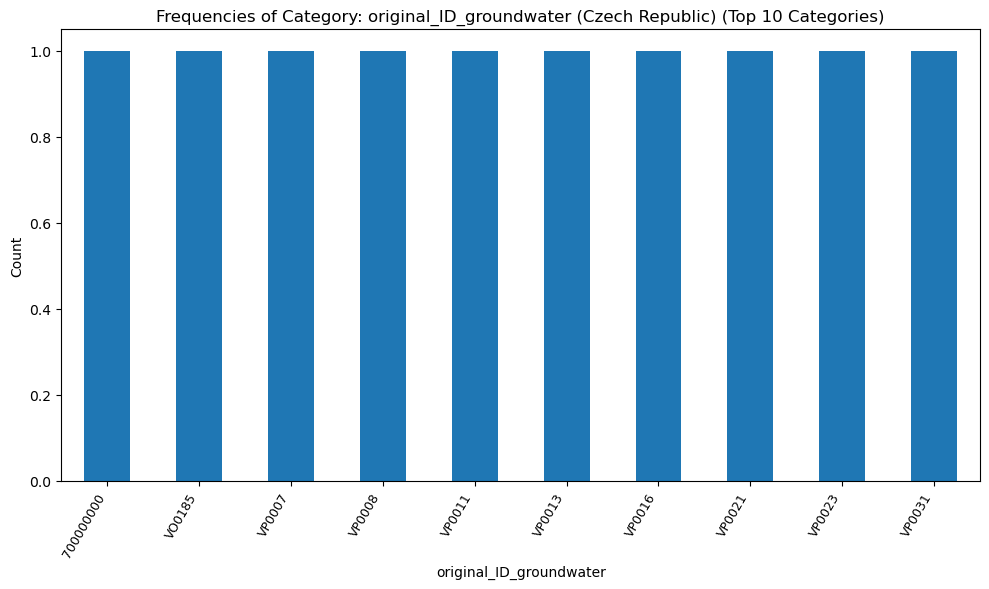

Column 'name' in CZE data has too many unique values (651). Plotting top 10 most frequent categories.


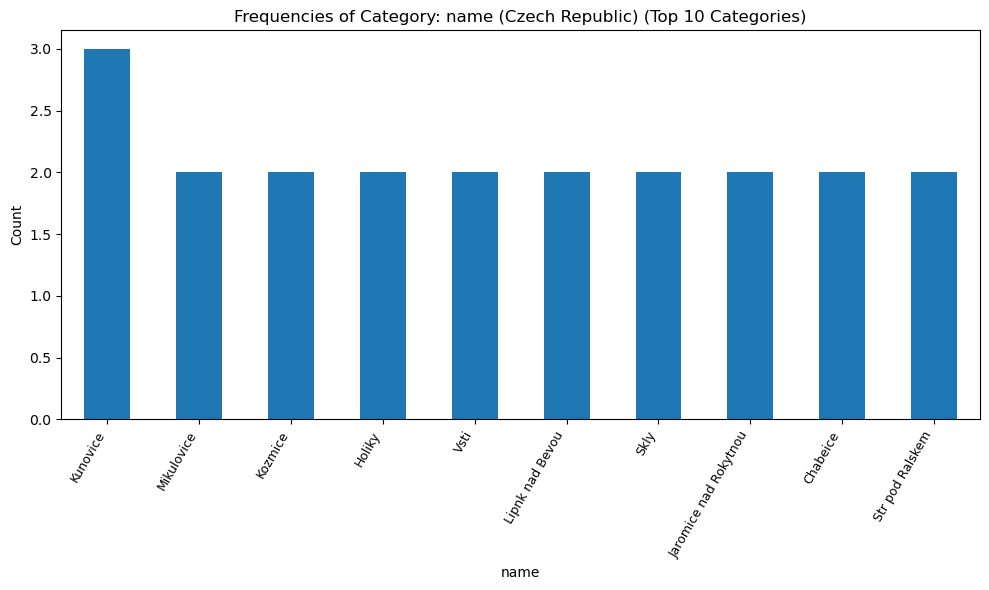

Plotting all 1 unique values for 'feature_type' in CZE data.


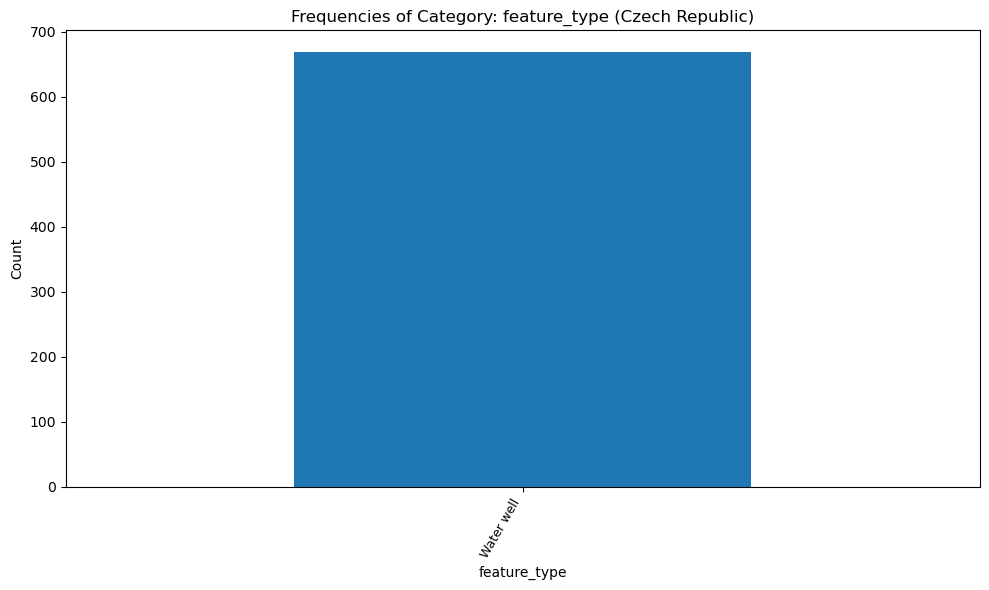

Plotting all 1 unique values for 'purpose' in CZE data.


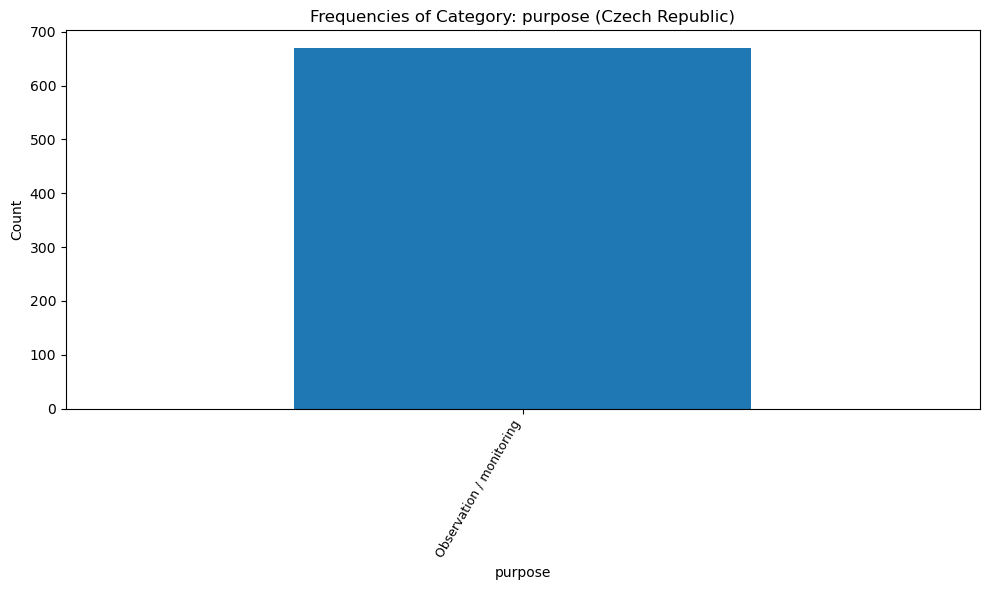

Plotting all 1 unique values for 'status' in CZE data.


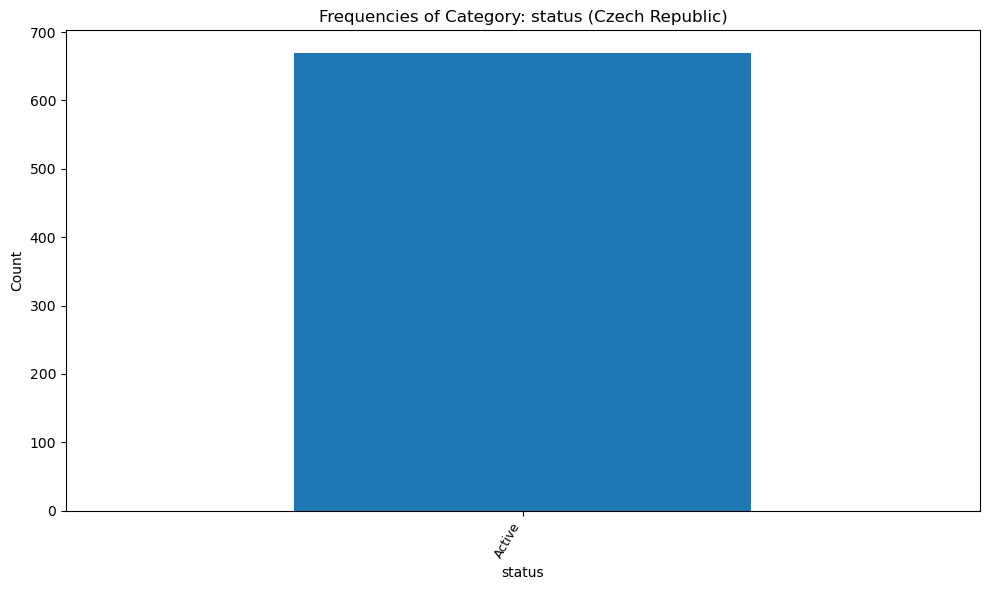

Column 'description' in CZE data is empty after dropping NA. Skipping bar chart.
Plotting all 1 unique values for 'country' in CZE data.


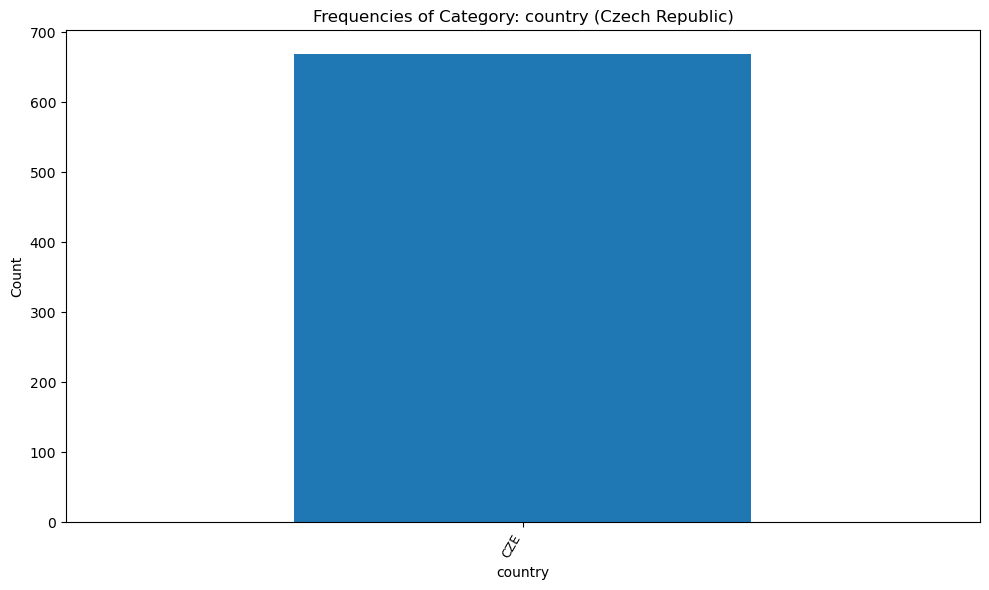

Column 'address' in CZE data is empty after dropping NA. Skipping bar chart.
Plotting all 2 unique values for 'license' in CZE data.


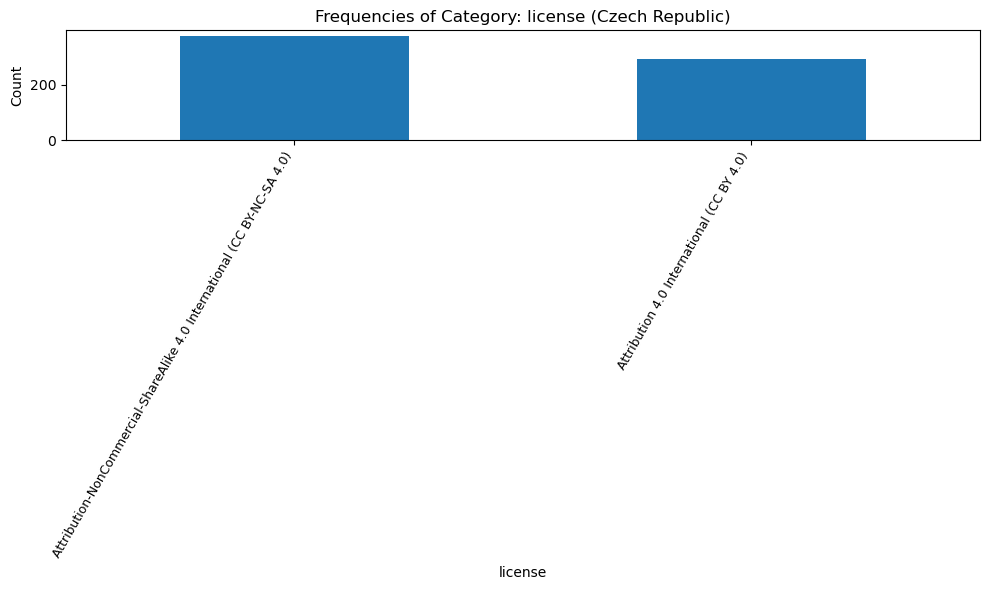

Column 'aquifer_name' in CZE data is empty after dropping NA. Skipping bar chart.
Column 'confinement' in CZE data is empty after dropping NA. Skipping bar chart.
Plotting all 2 unique values for 'organisation' in CZE data.


C:\Users\tarik\AppData\Local\Temp\ipykernel_12120\4132356404.py:106: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


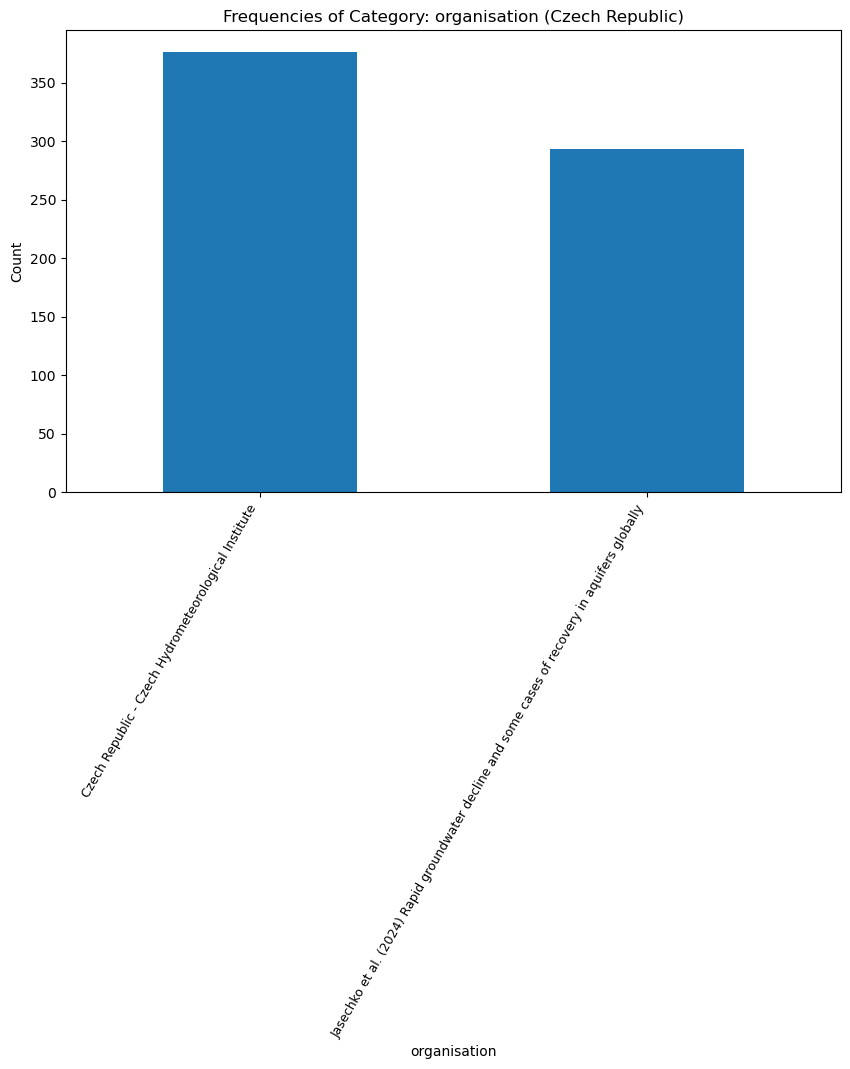

Column 'manager' in CZE data is empty after dropping NA. Skipping bar chart.
Plotting all 2 unique values for 'interval' in CZE data.


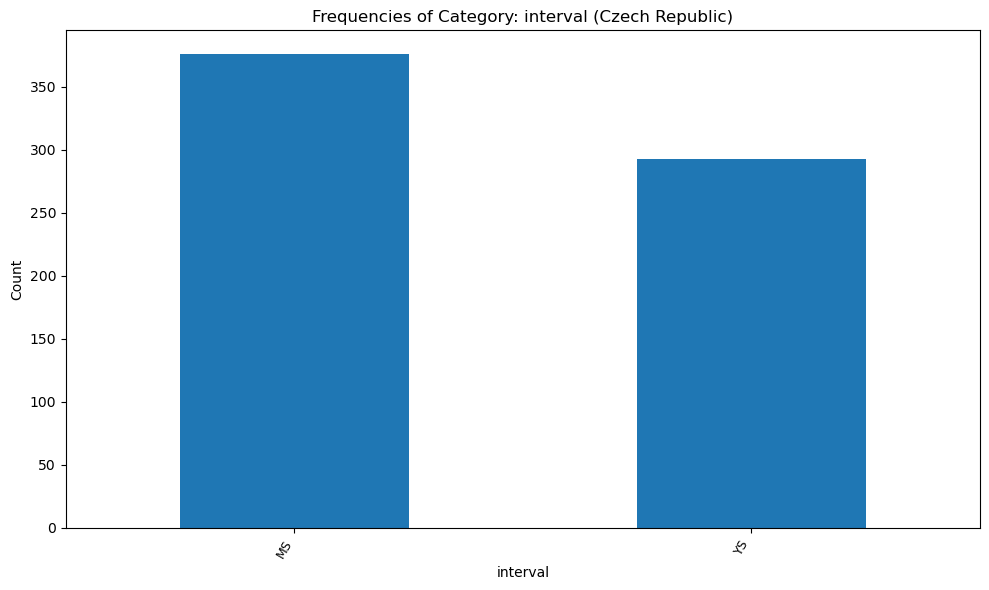

Column 'starting_date' in CZE data has too many unique values (87). Plotting top 10 most frequent categories.


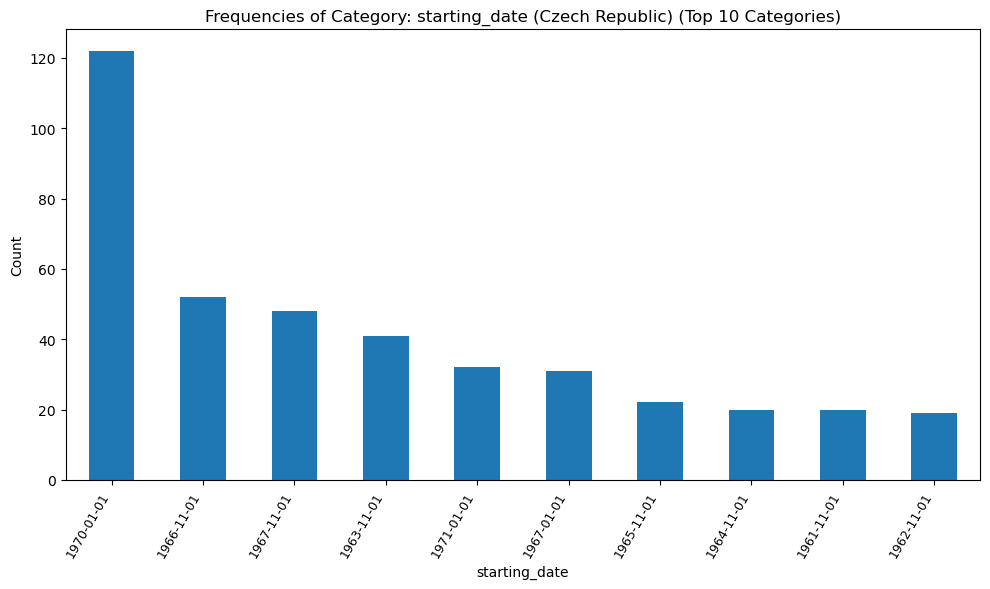

Plotting all 30 unique values for 'ending_date' in CZE data.


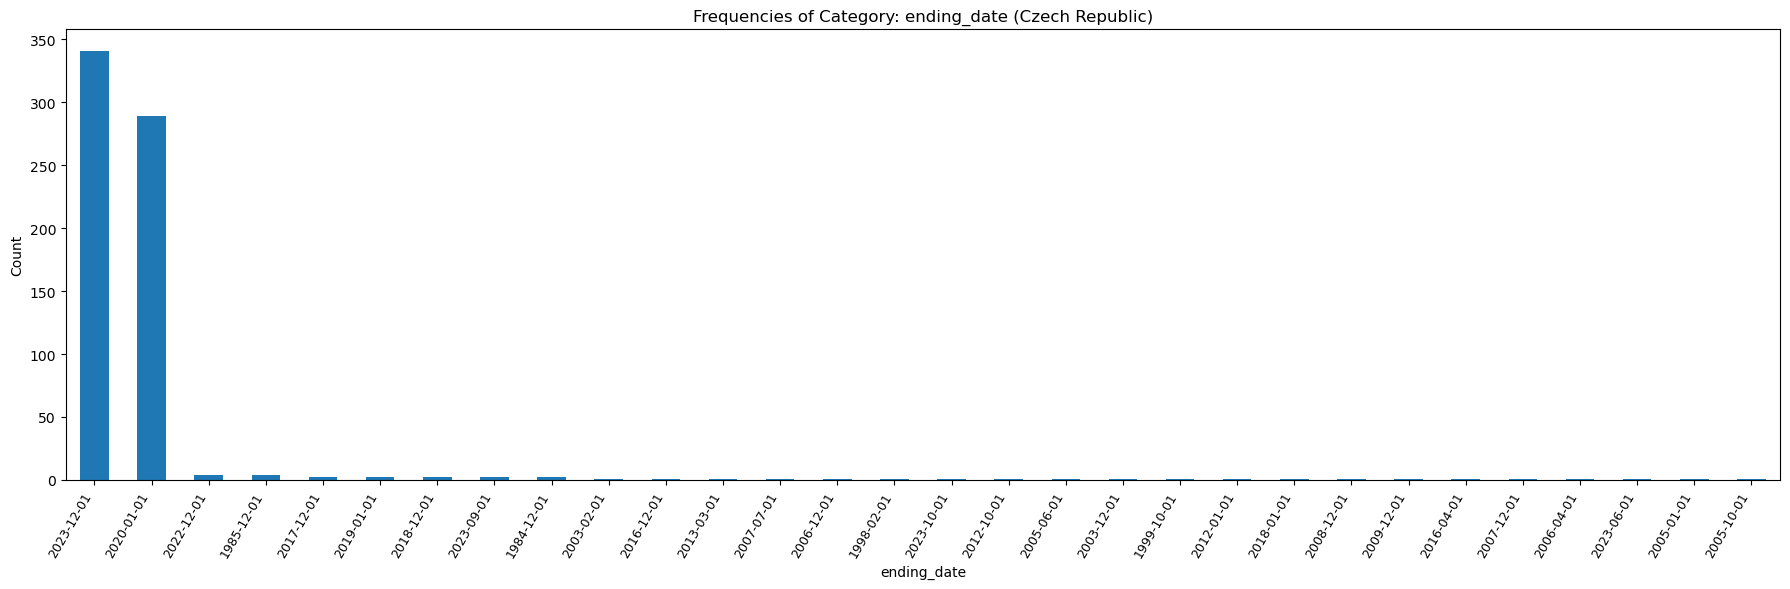

Plotting all 3 unique values for 'trend_direction' in CZE data.


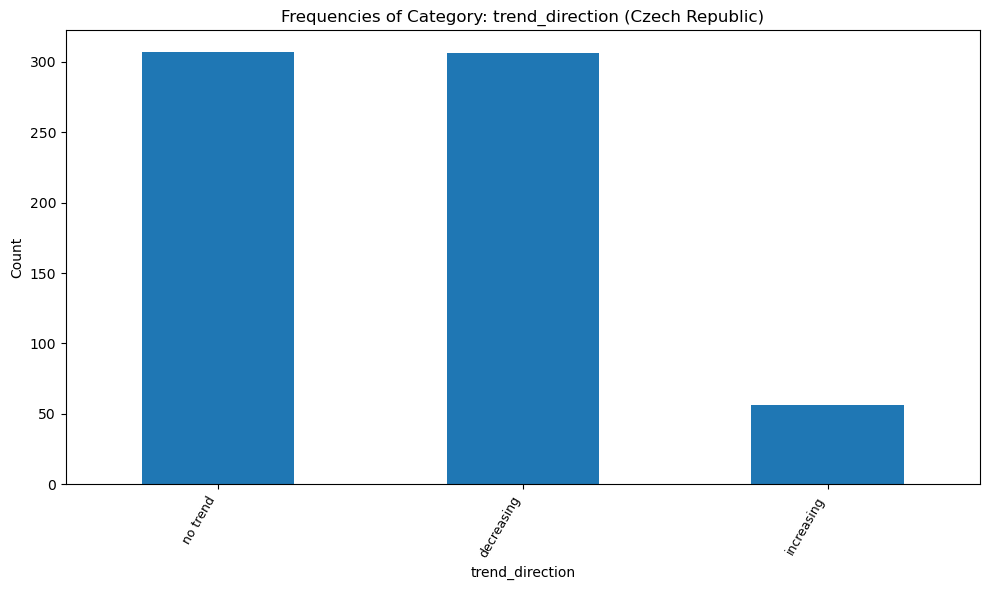

Plotting all 1 unique values for 'reference_point' in CZE data.


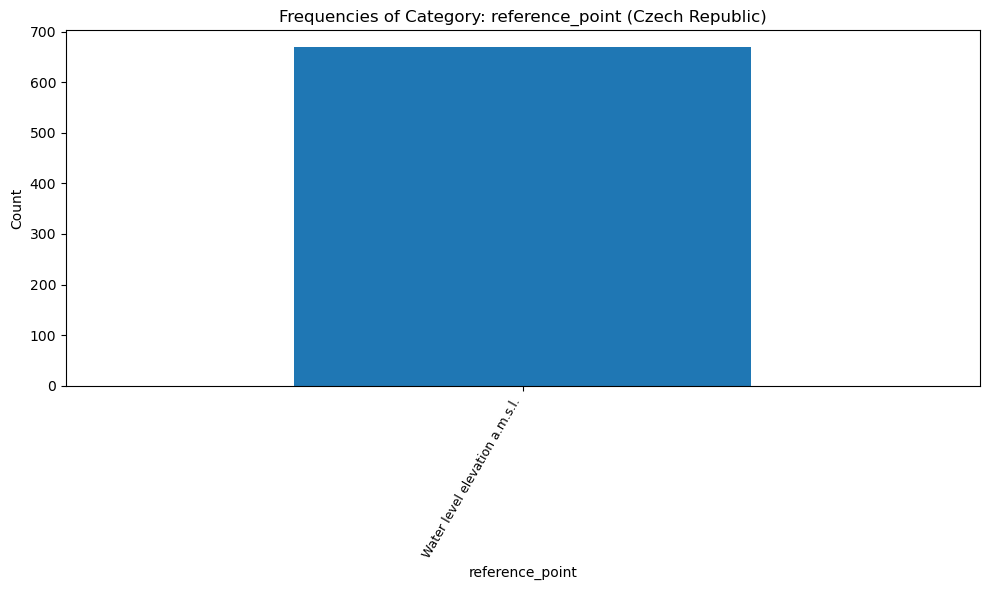

Plotting all 2 unique values for 'koeppen_geiger_class' in CZE data.


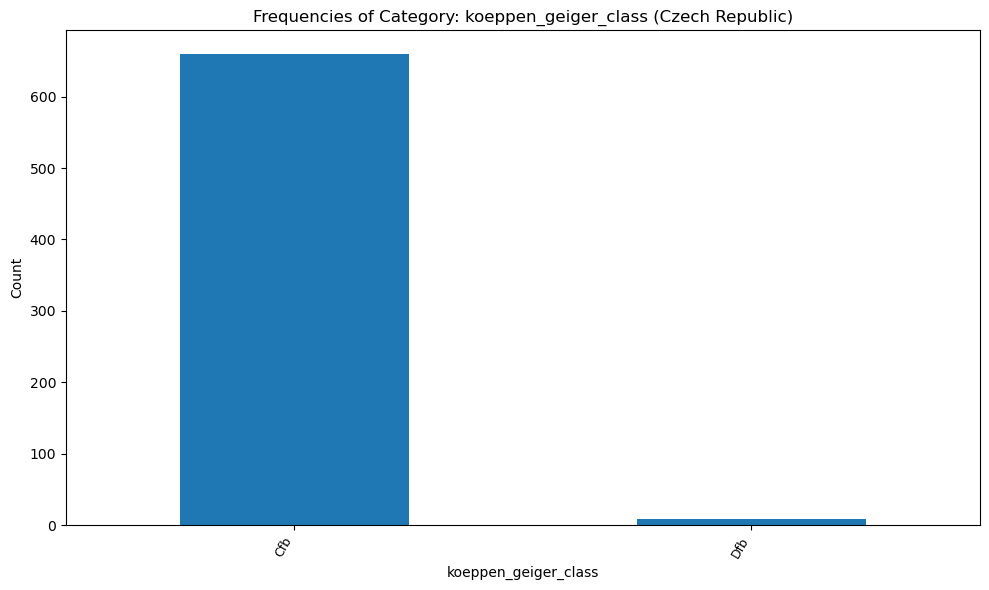

Plotting all 1 unique values for 'hydrobelt_class' in CZE data.


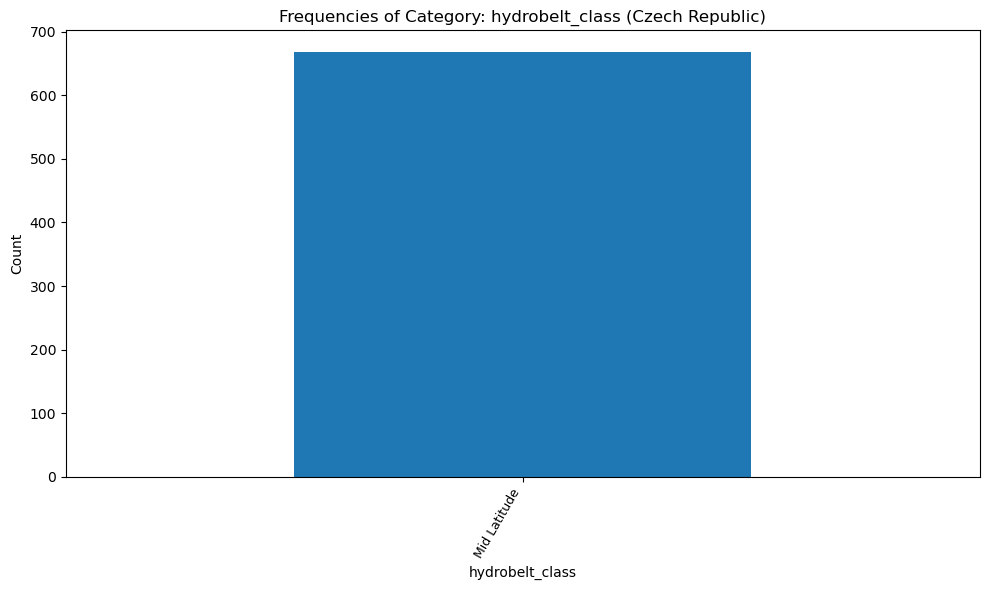

Plotting all 10 unique values for 'rock_type_class' in CZE data.


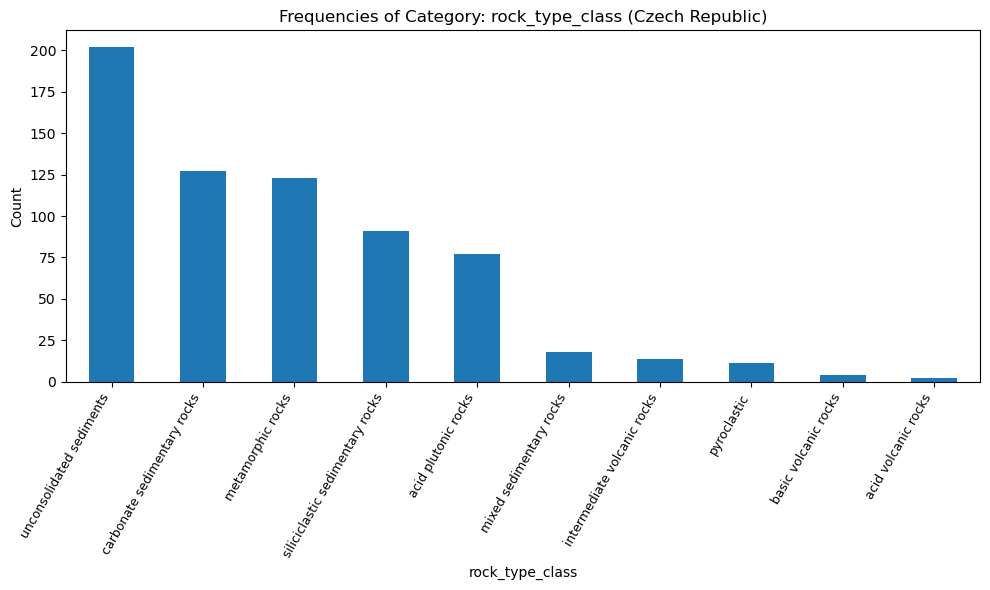

Plotting all 3 unique values for 'aquifer_type_class' in CZE data.


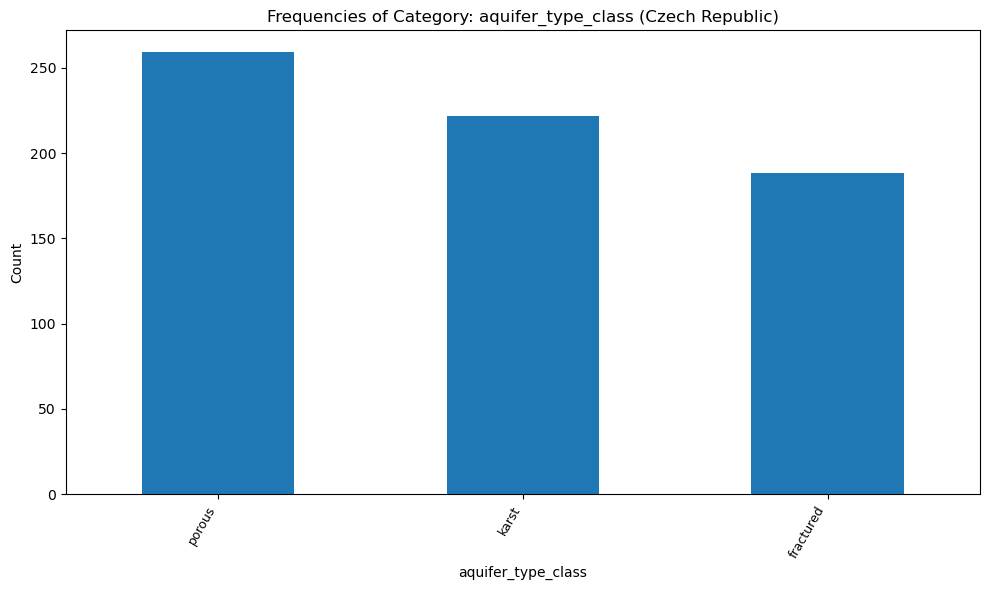

Plotting all 4 unique values for 'soil_texture_0-30_cm_class' in CZE data.


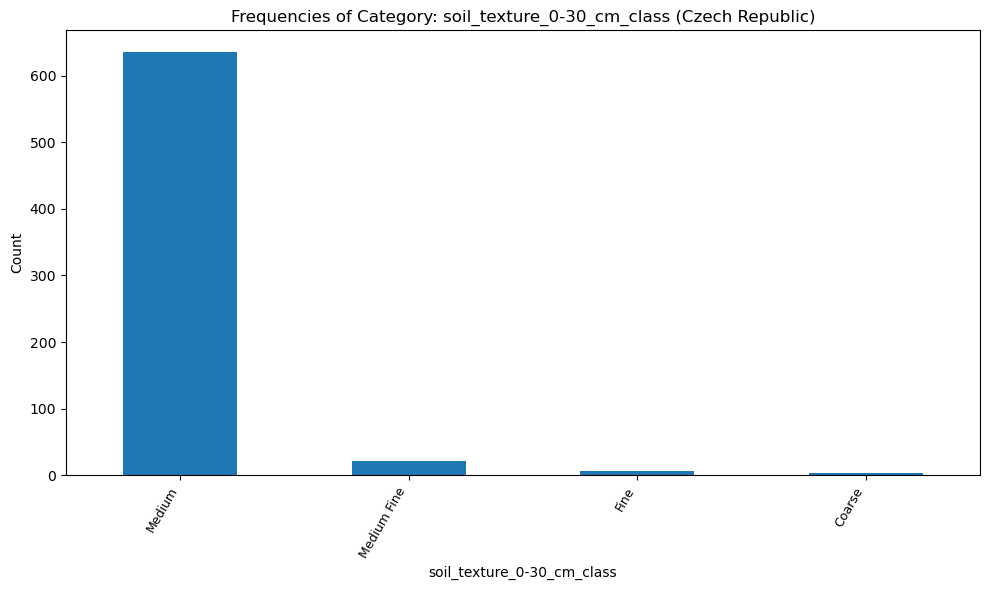

Plotting all 3 unique values for 'soil_texture_30-200_cm_class' in CZE data.


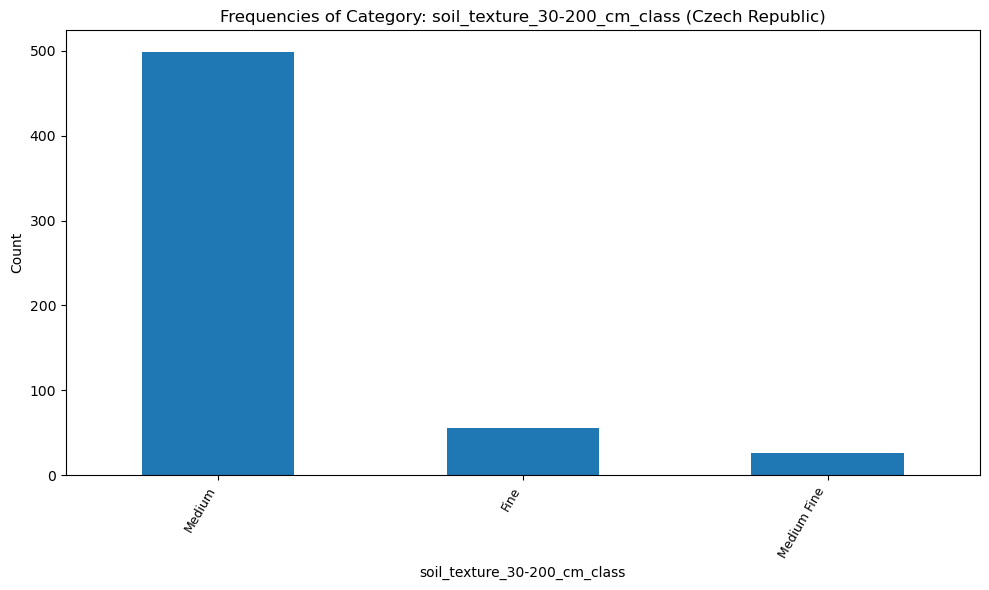

Plotting all 6 unique values for 'groundwater_dependent_ecosystems_class' in CZE data.


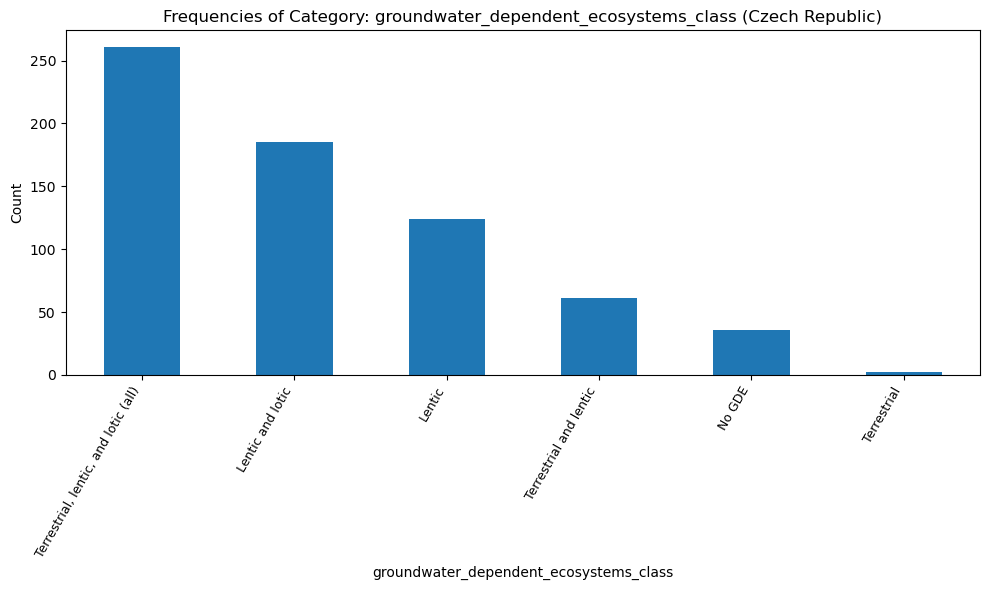

Plotting all 2 unique values for 'main_landuse' in CZE data.


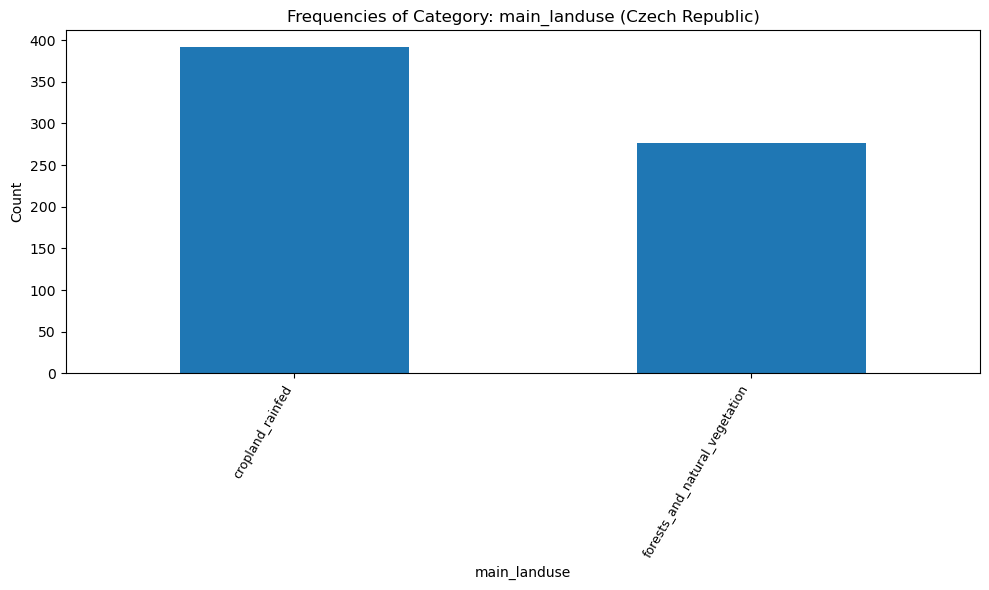

In [83]:
# Additional general histograms and boxplots for CZE data 

print("\nFurther detailed plots for Czech Republic (CZE) data:")

# Overview: Missing values for CZE data
print("\nMissing values for Czech Republic (CZE) data:")
print(df_cz.isnull().sum())

# Histograms of numerical features for CZE
# This provides individual histograms for all relevant numerical columns, useful for understanding their distributions.
numeric_cols_cz_detailed = df_cz.select_dtypes(include='number').columns
if not numeric_cols_cz_detailed.empty:
    numeric_cols_with_data = [col for col in numeric_cols_cz_detailed if df_cz[col].dropna().nunique() > 1]
    
    if numeric_cols_with_data:
        # Determine number of rows/columns for subplots
        n_plots = len(numeric_cols_with_data)
        n_cols = 3 
        n_rows = (n_plots + n_cols - 1) // n_cols # Calculate rows needed

        fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes_hist = axes_hist.flatten() 

        for i, col in enumerate(numeric_cols_with_data):
            data = df_cz[col].dropna()
            N = data.count()
            mean = data.mean()
            median = data.median()
            min_val = data.min()
            max_val = data.max()

            data.hist(bins=30, ax=axes_hist[i], edgecolor='black')
            axes_hist[i].set_title(
                f"{col} (CZE)\nN={N} – Mittelwert={mean:.2f} – Median={median:.2f} – Min={min_val:.2f} – Max={max_val:.2f}",
                fontsize=10
            )
            axes_hist[i].set_xlabel('') # Clear x-label to prevent overlap in subplots
            axes_hist[i].set_ylabel('') # Clear y-label
            
        # Hide any unused subplots
        for j in range(i + 1, len(axes_hist)):
            fig_hist.delaxes(axes_hist[j])

        plt.suptitle("Histograms of Numerical Features (Czech Republic)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
        plt.show()
    else:
        print("Not enough diverse numerical columns for histograms in CZE data found.")
else:
    print("No numerical columns for histograms in CZE data found.")

# Boxplots for outlier detection for CZE
# These boxplots help to visually identify potential outliers and the distribution of individual numerical features.
if not numeric_cols_cz_detailed.empty:
    for col in numeric_cols_cz_detailed:
        data = df_cz[col].dropna()
        if data.nunique() > 1:
            N = data.count()
            mean = data.mean()
            median = data.median()
            min_val = data.min()
            max_val = data.max()

            plt.figure(figsize=(10, 3)) # Slightly wider and taller for boxplots
            sns.boxplot(x=data, color='skyblue')
            plt.title(
                f"Boxplot of {col} (Czech Republic)\nN={N} – Mittelwert={mean:.2f} – Median={median:.2f} – Min={min_val:.2f} – Max={max_val:.2f}"
            )
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping Boxplot for '{col}' (Czech Republic): Not enough diverse or no non-missing values.")
else:
    print("No numerical columns for boxplots in CZE data found.")

# Bar charts for categorical features for CZE
# These plots show the frequency distribution of categorical attributes for stations in the Czech Republic.
categorical_cols_cz = df_cz.select_dtypes(include='object').columns
if not categorical_cols_cz.empty:
    for col in categorical_cols_cz:
        # Get value counts for Czech Republic data
        cz_value_counts = df_cz[col].value_counts()
        
        if cz_value_counts.empty:
            print(f"Column '{col}' in CZE data is empty after dropping NA. Skipping bar chart.")
            continue

        # Check if the number of categories is reasonable for a bar chart
        if len(cz_value_counts) < 35: # Plot all if less than 35 unique values
            plot_data = cz_value_counts
            title_suffix = ""
            print(f"Plotting all {len(cz_value_counts)} unique values for '{col}' in CZE data.")
        else: # If 35 or more unique values, plot top 10
            plot_data = cz_value_counts.head(10)
            title_suffix = " (Top 10 Categories)"
            print(f"Column '{col}' in CZE data has too many unique values ({len(cz_value_counts)}). Plotting top 10 most frequent categories.")

        fig_width = max(10, len(plot_data) * 0.6) # Dynamic width based on number of categories
        plt.figure(figsize=(fig_width, 6))

        plot_data.plot(kind='bar')
        plt.title(f'Frequencies of Category: {col} (Czech Republic){title_suffix}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=60, ha='right', fontsize=9) # Rotate and adjust alignment for readability
        plt.tight_layout()
        plt.show()
else:
    print("No categorical columns for bar charts in CZE data found.")
